In [1]:
import os

import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import shap

import utils

/mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/env-jl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
load_dotenv()

connection_string = "postgresql://{user}:{password}@{host}:{port}/{db}".format(
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT'),
    db=os.getenv('DB_NAME')
)
engine = create_engine(connection_string)

In [4]:
query = """
WITH
aggregated AS (
    SELECT
        launch,
        date,
        ARRAY_AGG(dalr ORDER BY height_amsl) AS dalr,
        ARRAY_AGG(temperature_c ORDER BY height_amsl) AS temperature_c,
        ARRAY_AGG(height_amsl ORDER BY height_amsl) AS height_amsl
    FROM glideator_int.int_temp_amsl
    GROUP BY 1, 2
),
dewpoint AS (
    SELECT
        launch,
        date,
        dewpoint_c
    FROM glideator_stage.stg_dewpoint
),
wind AS (
    SELECT
        launch,
        date,
        u_wind_ms,
        v_wind_ms
    FROM glideator_stage.stg_wind_height
    WHERE height_m = 10
),
water AS (
    SELECT
        launch,
        date,
        precipitable_water_kgm2
    FROM glideator_stage.stg_precipitation
),
launches AS (
    SELECT 
    	name AS launch,
    	altitude,
    	superelevation
    FROM glideator_mart.dim_launches
    WHERE name != 'Řevničov'
),
stats AS (
    SELECT 
        * 
    FROM glideator_mart.mart_daily_flight_stats
),
stats_w_weather AS (
    SELECT
        stats.*,
        aggregated.dalr,
        aggregated.temperature_c,
        aggregated.height_amsl,
        dewpoint_c,
        aggregated.temperature_c[1] AS temperature_c_surface,
        water.precipitable_water_kgm2,
        u_wind_ms,
        v_wind_ms,
    	altitude,
    	superelevation
    FROM stats
    JOIN aggregated
        ON stats.launch = aggregated.launch
        AND stats.date = aggregated.date
    JOIN dewpoint
        ON stats.launch = dewpoint.launch
        AND stats.date = dewpoint.date
    JOIN wind
        ON stats.launch = wind.launch
        AND stats.date = wind.date
    JOIN launches
        ON stats.launch = launches.launch
    JOIN water
        ON stats.launch = water.launch
        AND stats.date = water.date
)

SELECT * FROM stats_w_weather
"""
df = pd.read_sql(query, engine)
df.head()

date launch  flight_registered  flight_cnt  max_points  max_length  \
0  2019-06-12   Brná                  0           0        0.00        0.00   
1  2019-06-13   Brná                  0           0        0.00        0.00   
2  2019-06-14   Brná                  0           0        0.00        0.00   
3  2019-06-15   Brná                  1           3        7.15        5.11   
4  2019-06-17   Brná                  0           0        0.00        0.00   

                                                dalr  \
0  [28.550012207031273, 27.810567095947288, 27.78...   
1  [21.570855712890648, 20.80645571289065, 20.610...   
2  [26.555932617187523, 25.791532617187524, 25.59...   
3  [28.897698974609398, 28.1332989746094, 27.9372...   
4  [22.850000000000023, 22.085600000000024, 21.88...   

                                       temperature_c  \
0  [28.550012207031273, 26.950006103515648, 26.85...   
1  [21.570855712890648, 19.311425781250023, 18.85...   
2  [26.555932617187523, 24.850000000000023, 24.85...   
3  [28.897698974609398, 27.850000000000023, 26.85...   
4  [22.850000000000023, 20.850000000000023, 20.85...   

                                         height_amsl  dewpoint_c  \
0  [425.25974, 500.71332, 503.25974, 523.25977, 7...   18.850000   
1  [425.25974, 503.25974, 523.25977, 569.69257, 7...   12.450006   
2  [425.25974, 503.25974, 523.25977, 602.3169, 83...   11.649988   
3  [425.25974, 503.25974, 523.25977, 548.0672, 78...   19.749994   
4  [425.25974, 503.25974, 523.25977, 623.4467, 85...   11.950006   

   temperature_c_surface  precipitable_water_kgm2  u_wind_ms  v_wind_ms  \
0              28.550012                     28.0  -3.828704   4.205854   
1              21.570856                     21.9   0.382566  -1.479607   
2              26.555933                     20.2  -1.514290   2.766934   
3              28.897699                     33.6   1.442749   2.058274   
4              22.850000                     21.3  -2.019816  -0.435315   

   altitude  superelevation  
0       450             300  
1       450             300  
2       450             300  
3       450             300  
4       450             300

In [5]:
df['area_under_dalr'] = df.apply(lambda row: utils.area_under_darl(row['dalr'], row['temperature_c'], row['height_amsl']), axis=1)
df['thermal_top'] = df.apply(lambda row: utils.thermal_top(row['dalr'], row['temperature_c'], row['height_amsl']), axis=1)
df['thermal_strenght'] = df.apply(lambda row: np.max(np.array(row['dalr']) - np.array(row['temperature_c'])), axis=1)
df['temp_dewpoint_spread_surface'] = df['temperature_c_surface'] - df['dewpoint_c']
df['week_day'] = df['date'].apply(lambda date: date.weekday())

In [6]:
TARGET = 'flight_registered'
FEATURES = [
    'area_under_dalr',
    'thermal_strenght',
    'thermal_top',
    'dewpoint_c',
    'temperature_c_surface',
    'temp_dewpoint_spread_surface', 
    'precipitable_water_kgm2',
    'u_wind_ms',
    'v_wind_ms',
    'altitude',
    'superelevation',
    'launch',
    'week_day'
]

[0]	train-logloss:0.42919	eval-logloss:0.43372
[1]	train-logloss:0.39920	eval-logloss:0.40599
[2]	train-logloss:0.37660	eval-logloss:0.38534
[3]	train-logloss:0.36309	eval-logloss:0.37328
[4]	train-logloss:0.35411	eval-logloss:0.36595
[5]	train-logloss:0.34684	eval-logloss:0.35981
[6]	train-logloss:0.33639	eval-logloss:0.35114
[7]	train-logloss:0.32576	eval-logloss:0.34229
[8]	train-logloss:0.30979	eval-logloss:0.32883
[9]	train-logloss:0.30734	eval-logloss:0.32671
[10]	train-logloss:0.30241	eval-logloss:0.32310
[11]	train-logloss:0.29931	eval-logloss:0.32068
[12]	train-logloss:0.29722	eval-logloss:0.31922
[13]	train-logloss:0.29424	eval-logloss:0.31756
[14]	train-logloss:0.28707	eval-logloss:0.31171
[15]	train-logloss:0.28276	eval-logloss:0.30775
[16]	train-logloss:0.27960	eval-logloss:0.30581
[17]	train-logloss:0.27842	eval-logloss:0.30542
[18]	train-logloss:0.27415	eval-logloss:0.30121
[19]	train-logloss:0.26936	eval-logloss:0.29814
[20]	train-logloss:0.26575	eval-logloss:0.29506
[2

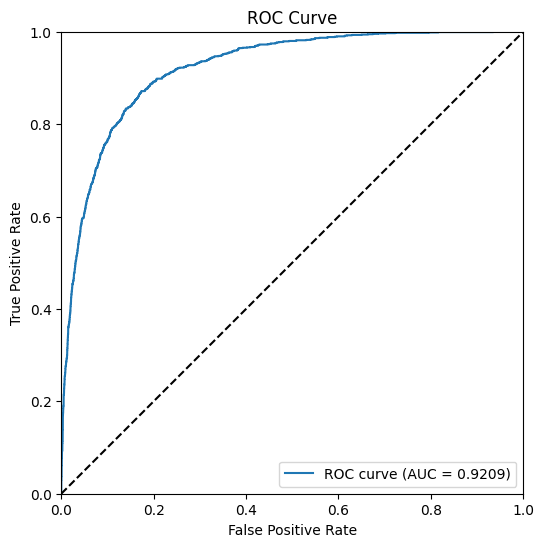

<Figure size 1000x800 with 0 Axes>

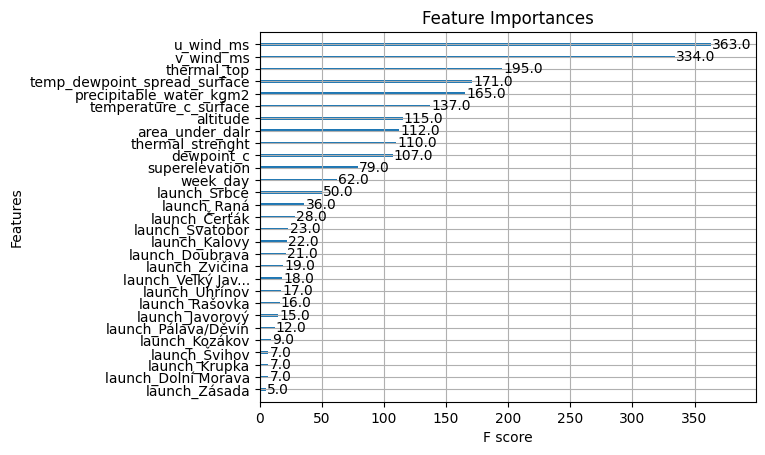

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define features and target
X = df[FEATURES] #query('launch == "Raná"')
y = df[TARGET] #query('launch == "Raná"')

# Encode 'launch' as one-hot encoded variables
X = pd.get_dummies(X, columns=['launch'], drop_first=True)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

# Train the model with early stopping
num_round = 1000
evallist = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(
    params,
    dtrain,
    num_round,
    evals=evallist,
    early_stopping_rounds=5,
    verbose_eval=True
)

# Predict probabilities on the validation set
y_pred_proba = model.predict(dval)

# Compute ROC-AUC
roc_auc = utils.plot_roc_curve(y_val, y_pred_proba)

# Plot feature importances
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=50)
plt.title('Feature Importances')
plt.show()

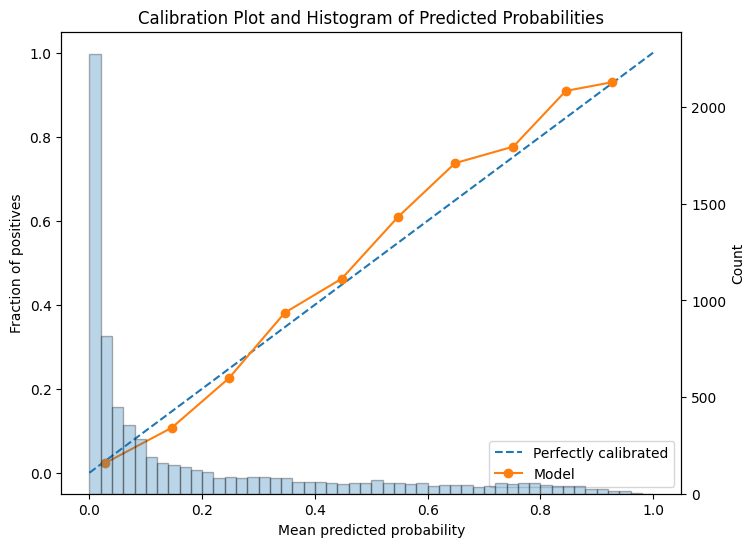

In [8]:
fig = utils.plot_calibration_and_histogram(y_val, y_pred_proba)
plt.show()

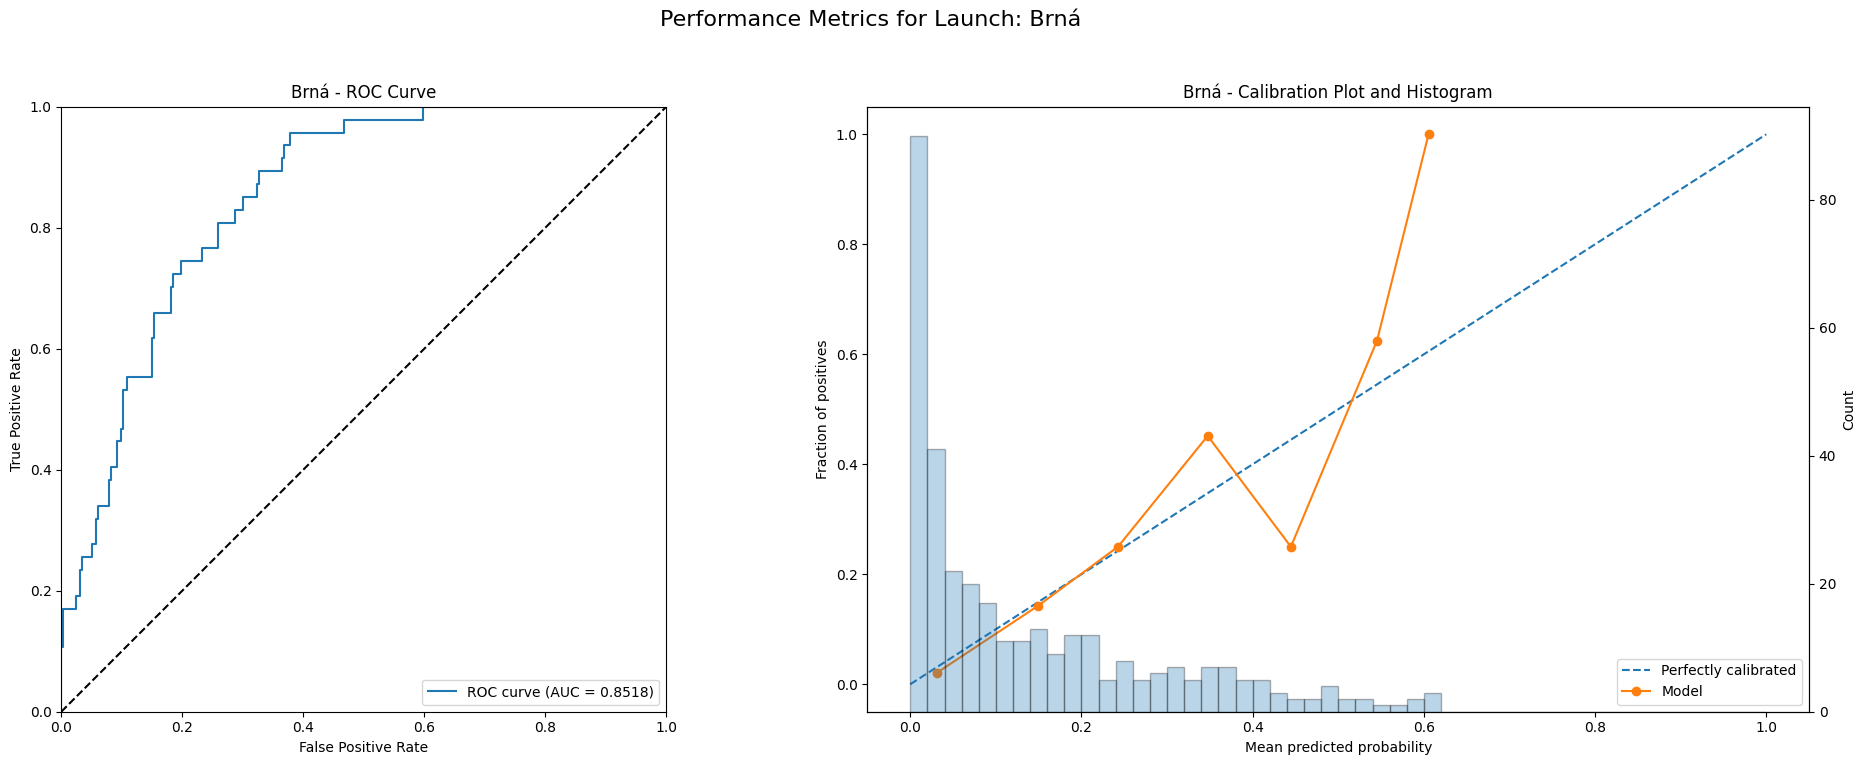

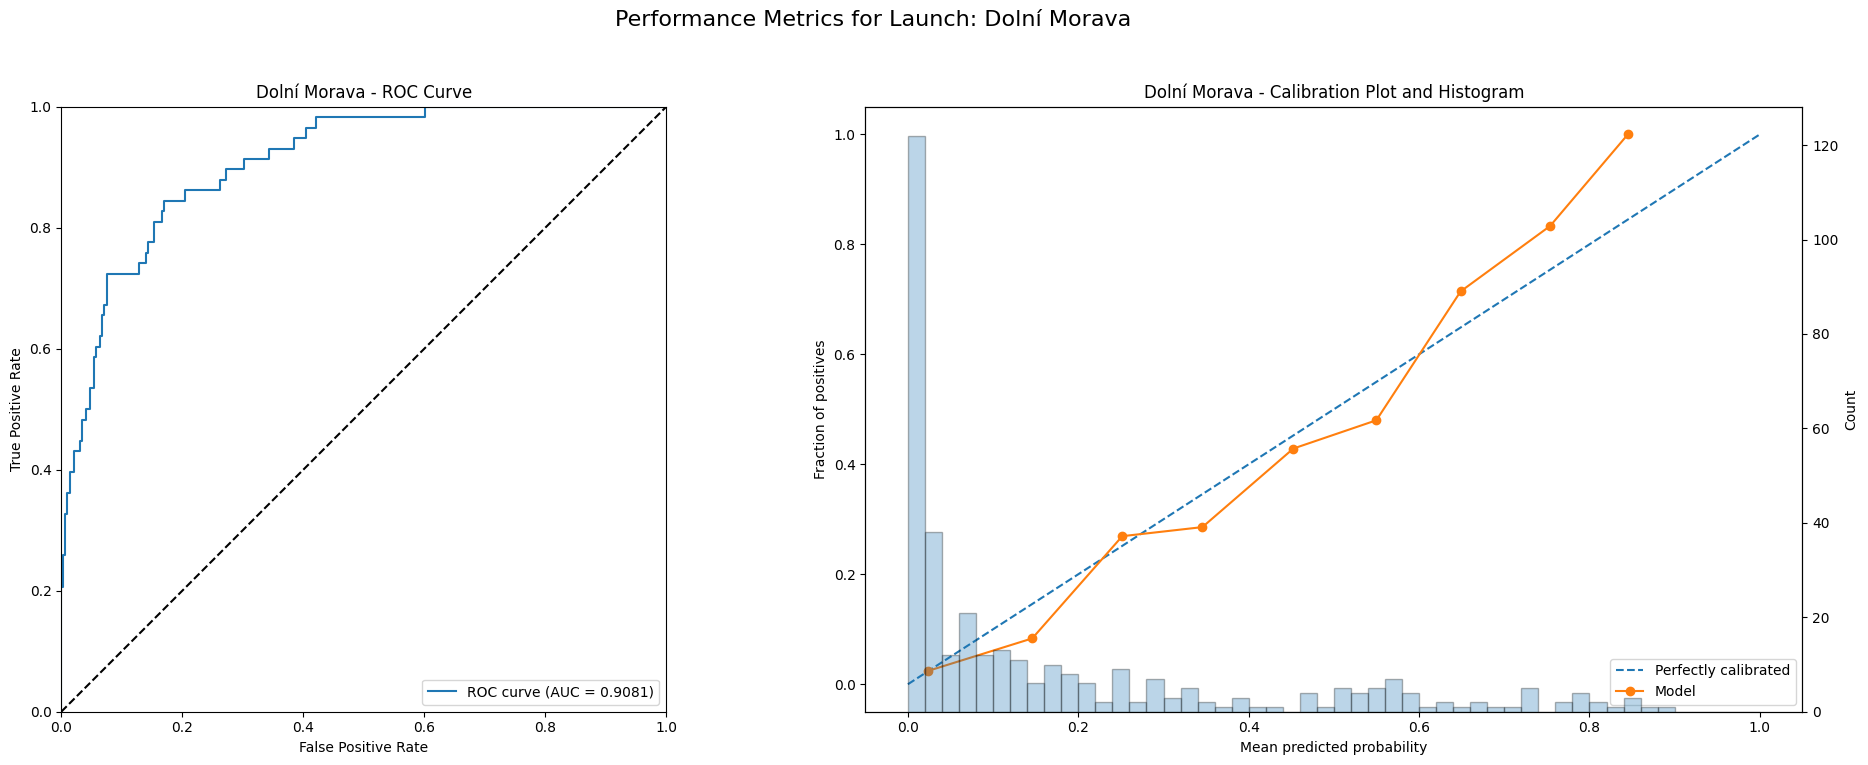

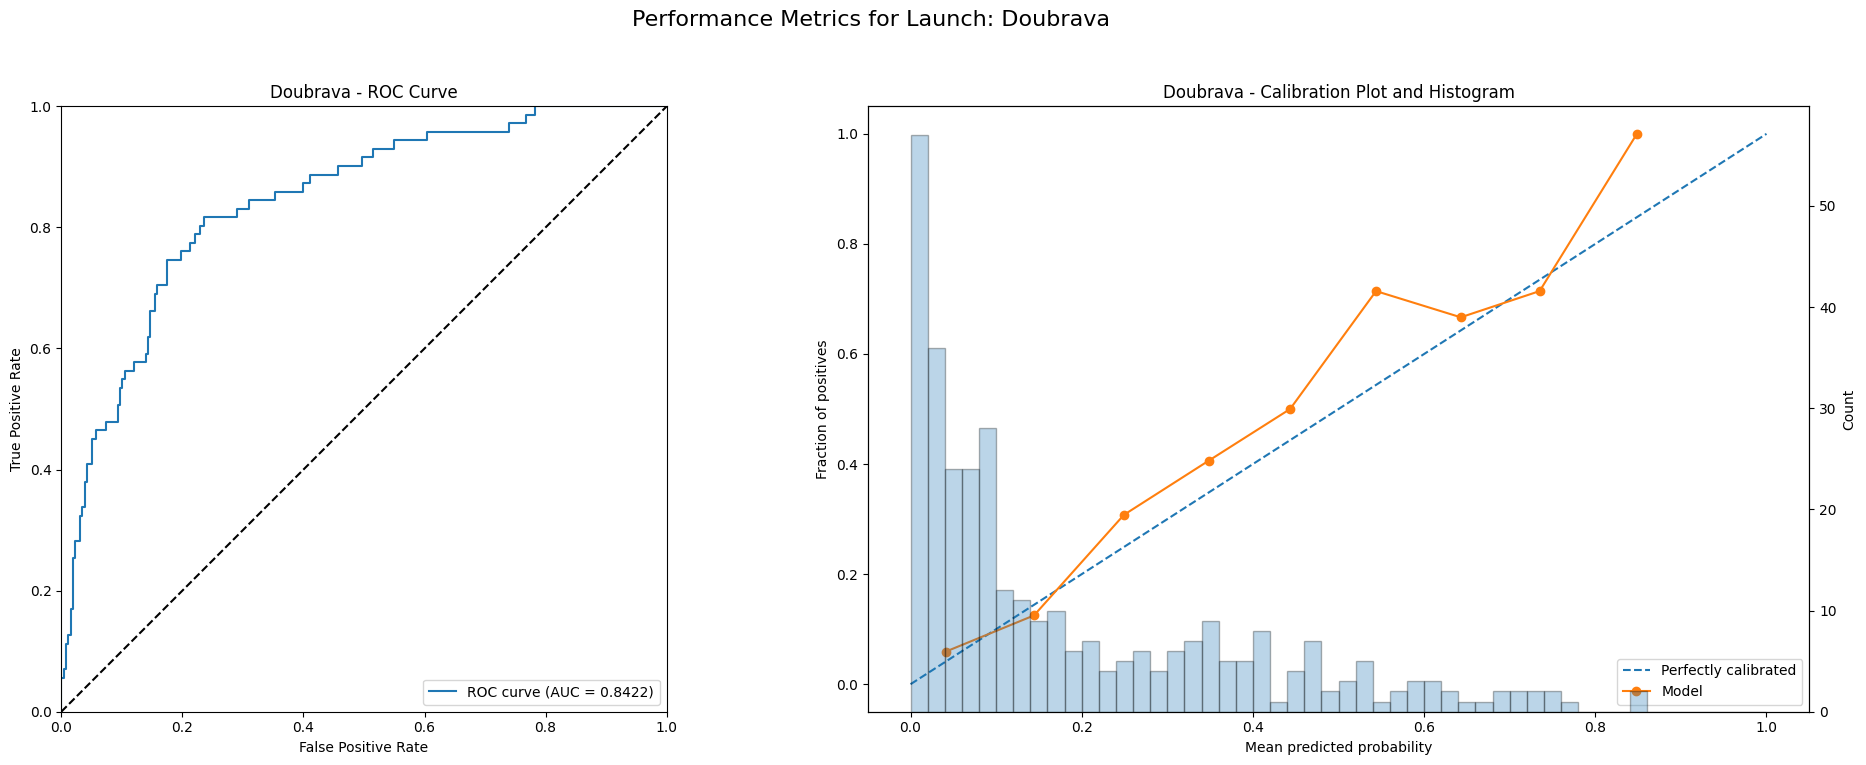

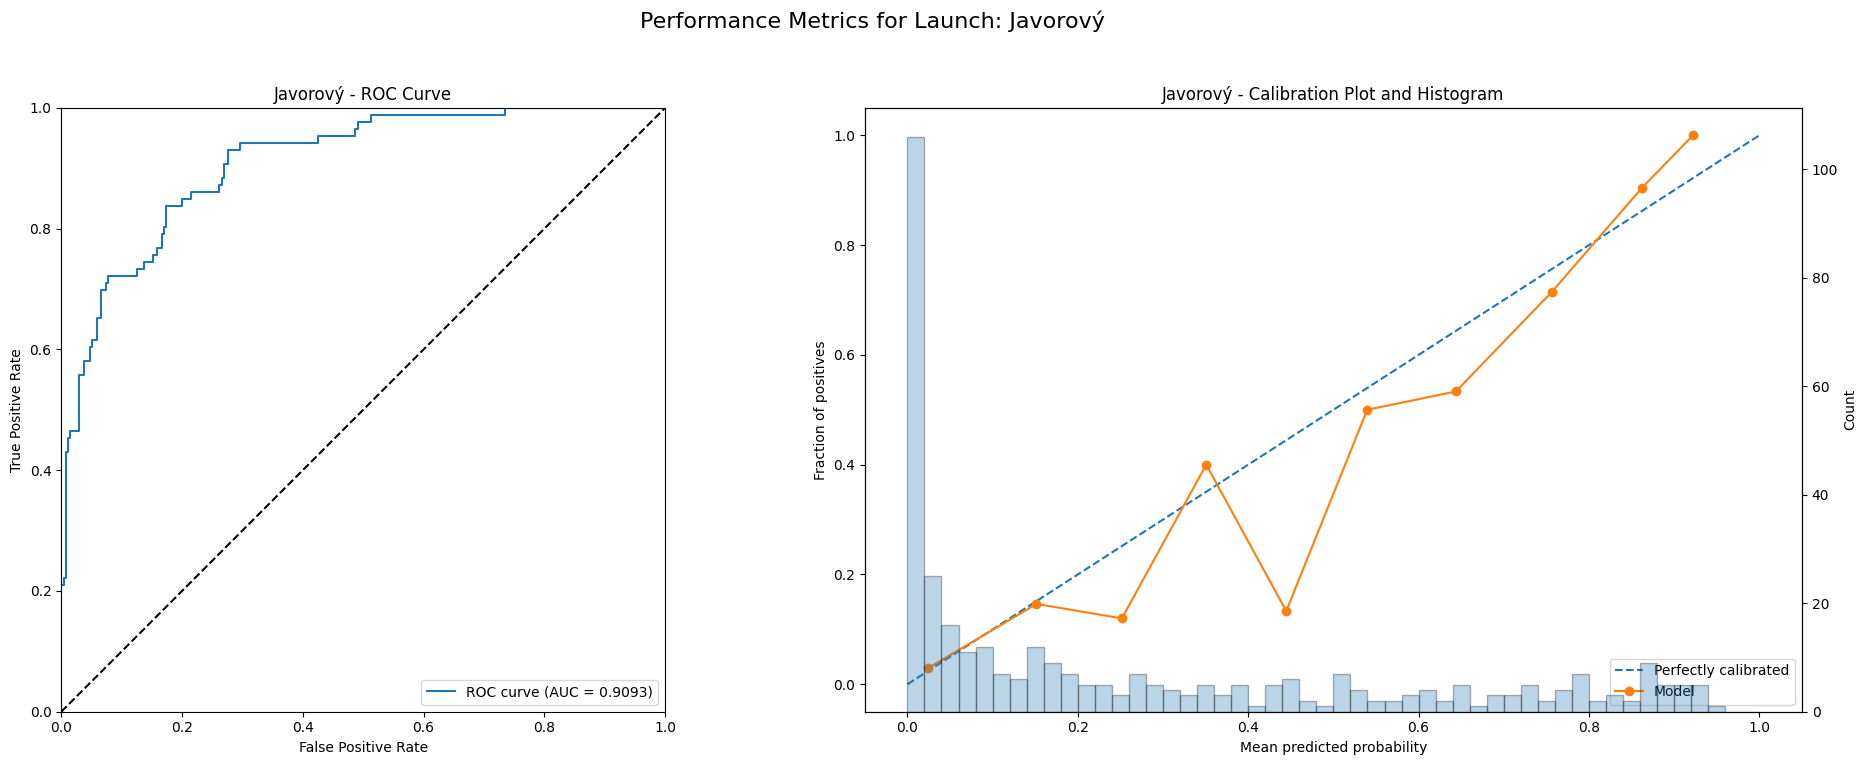

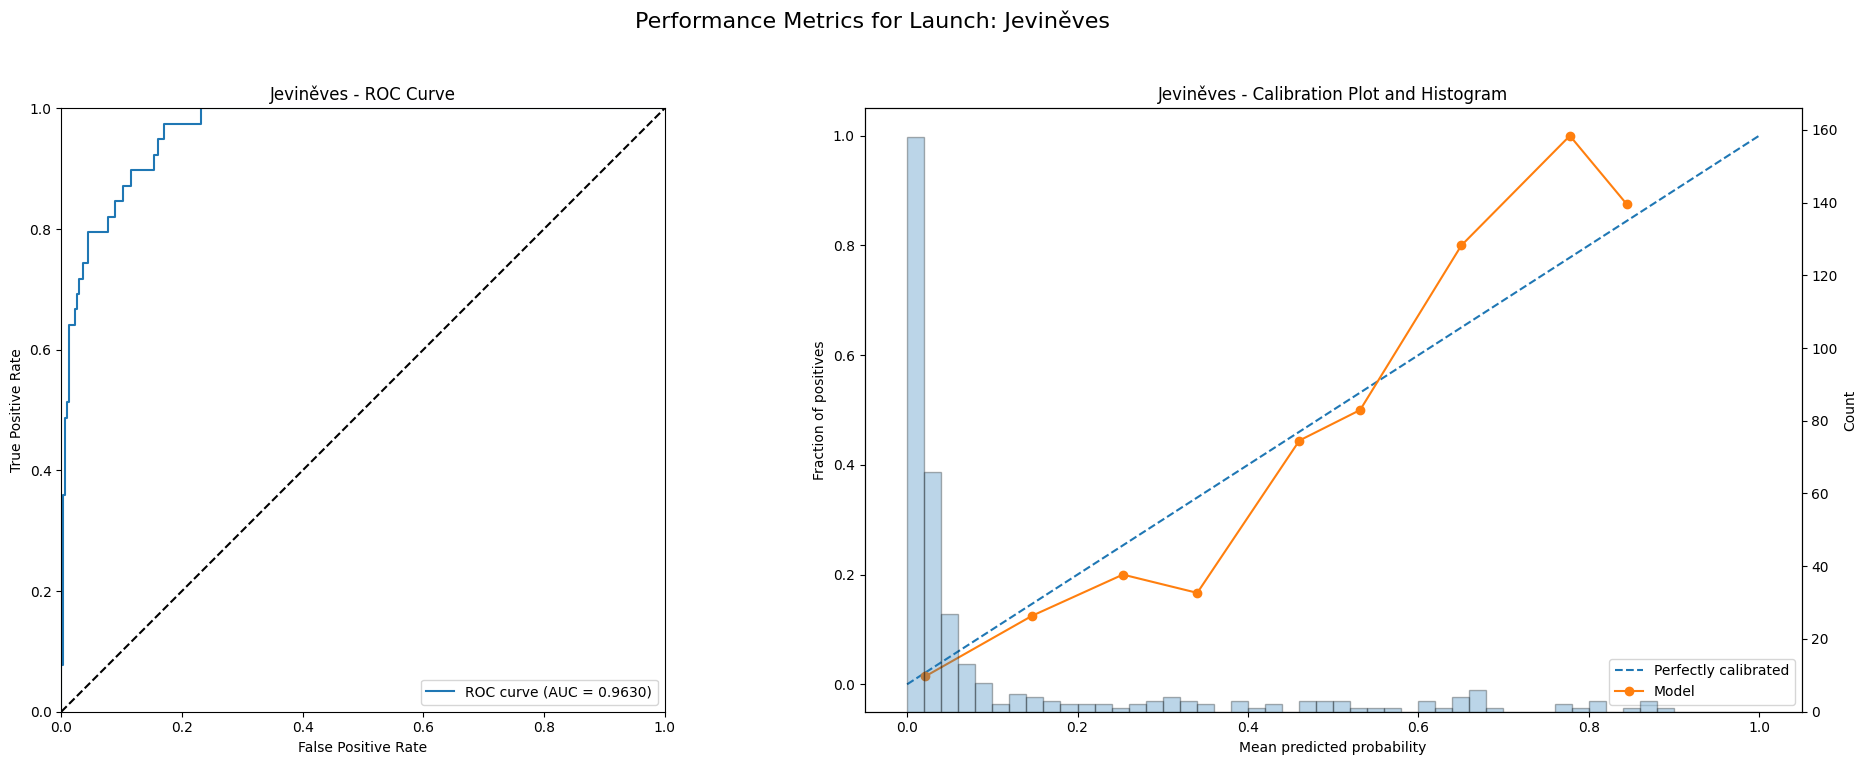

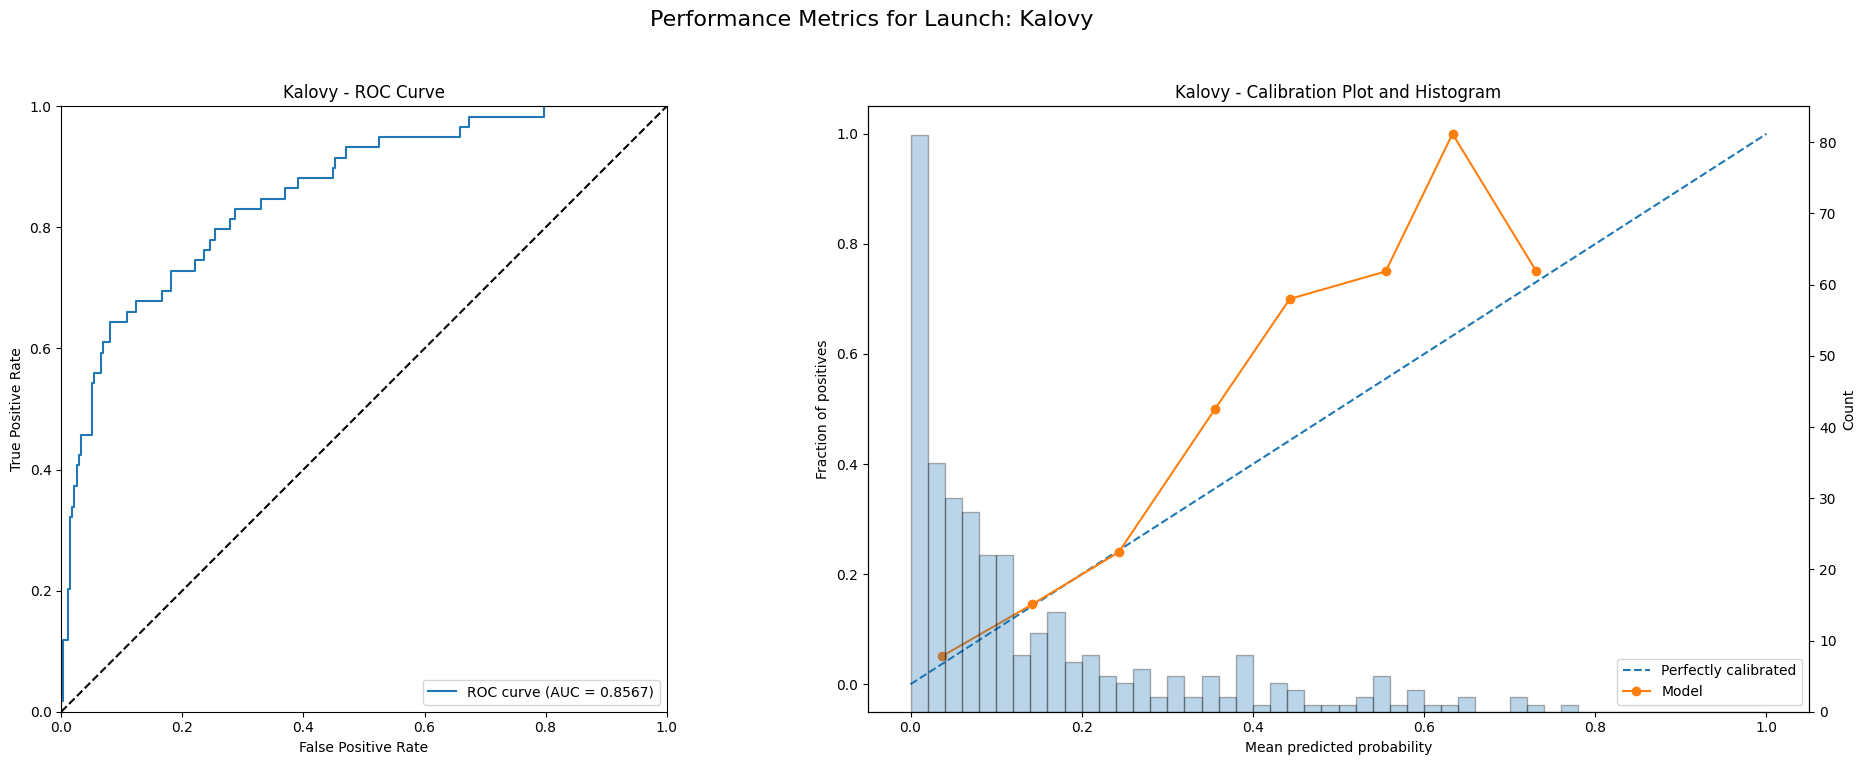

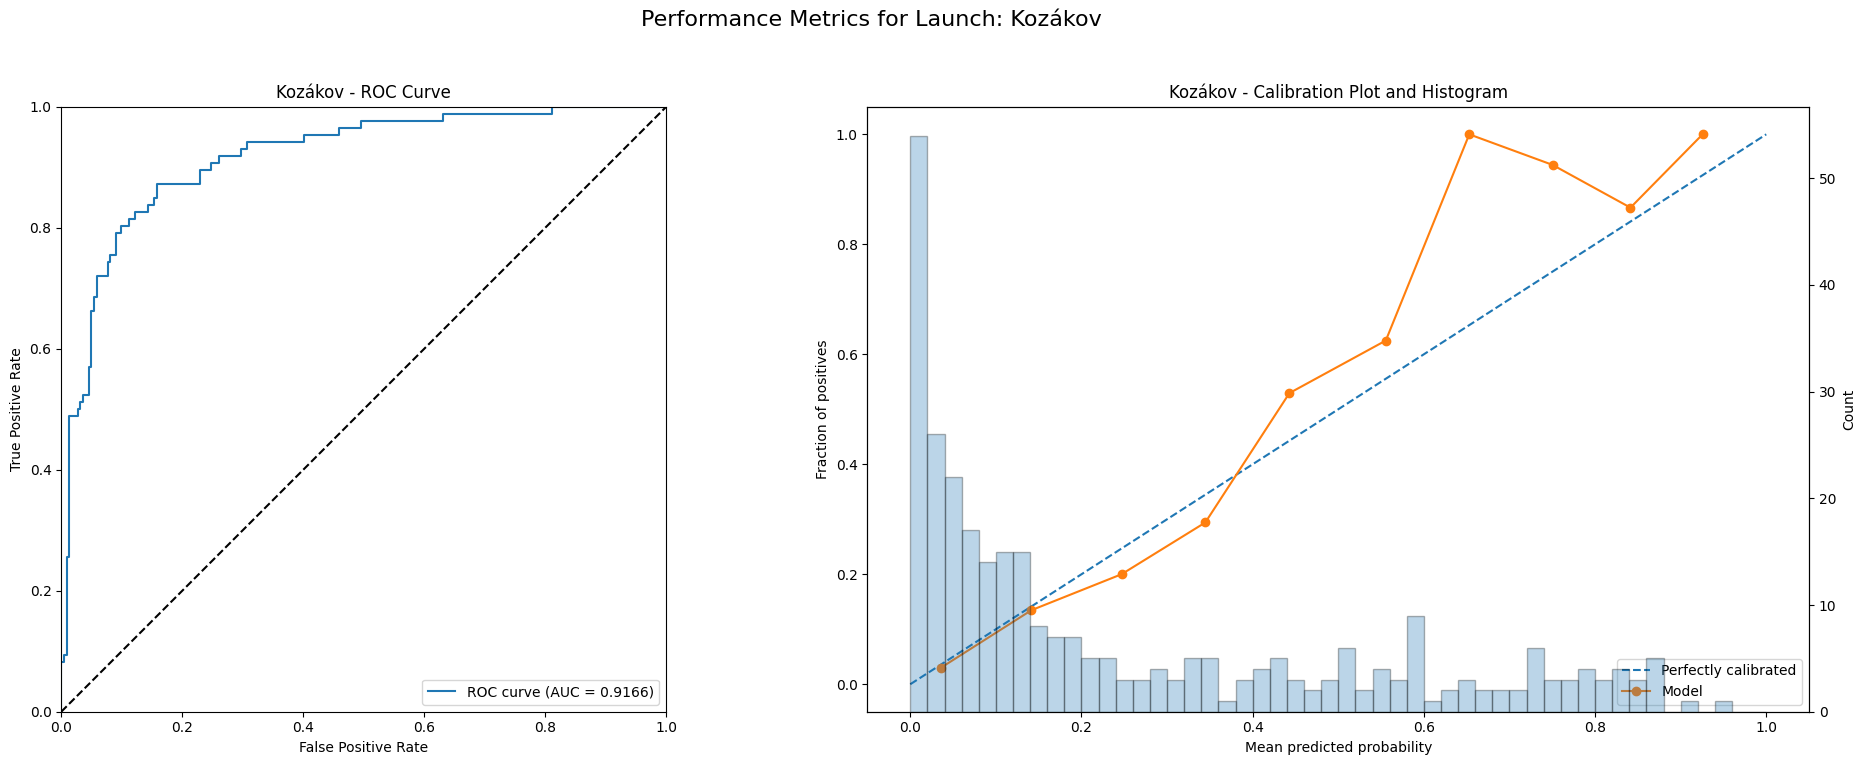

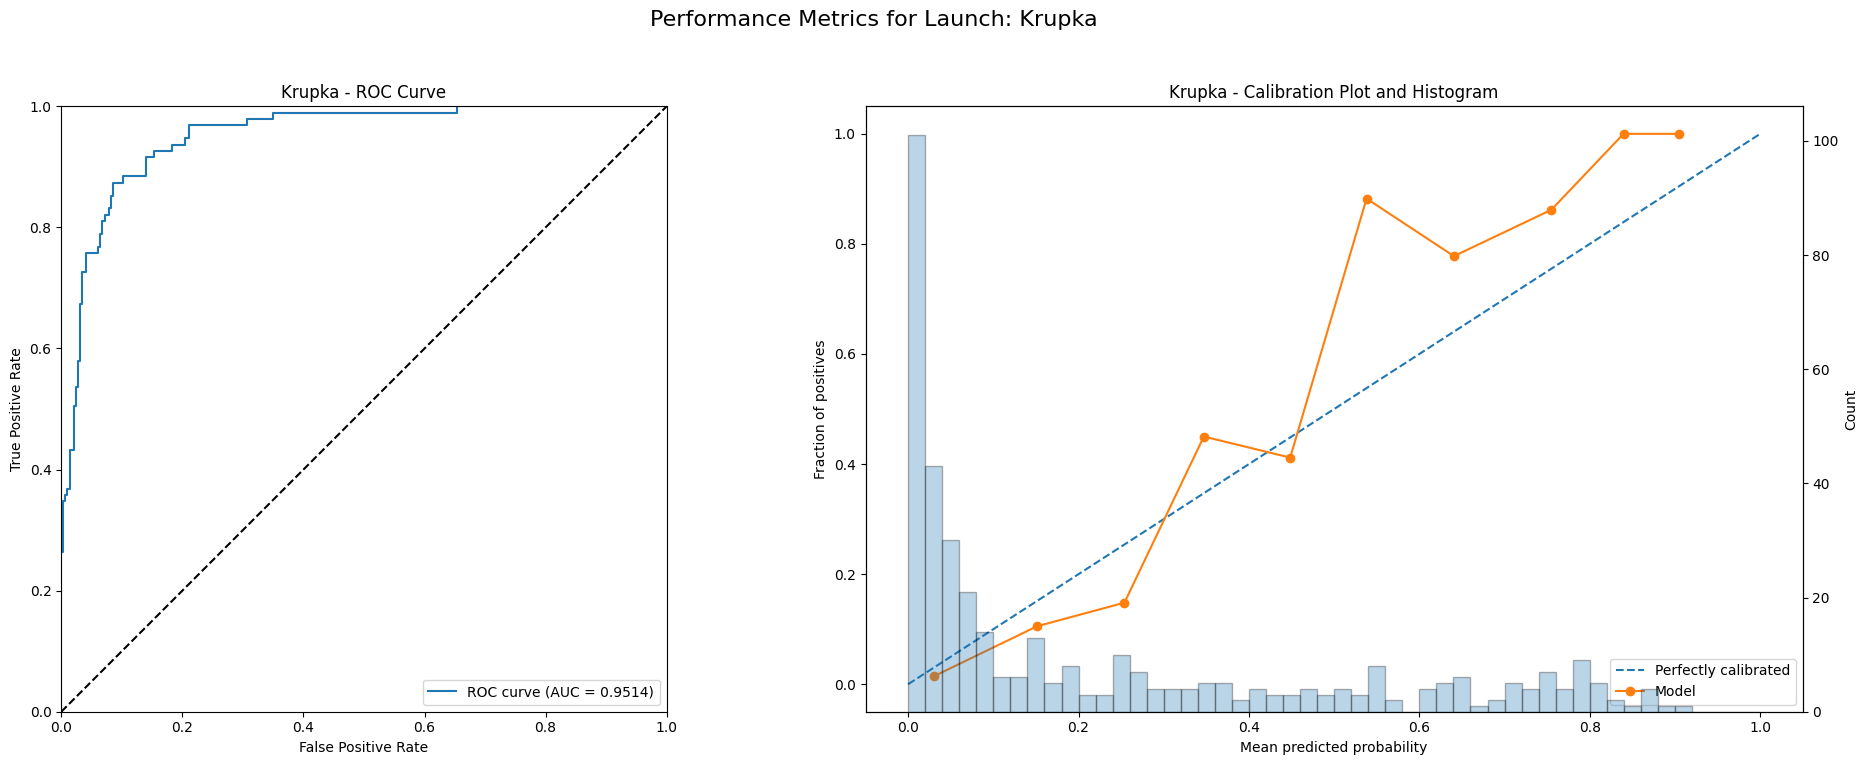

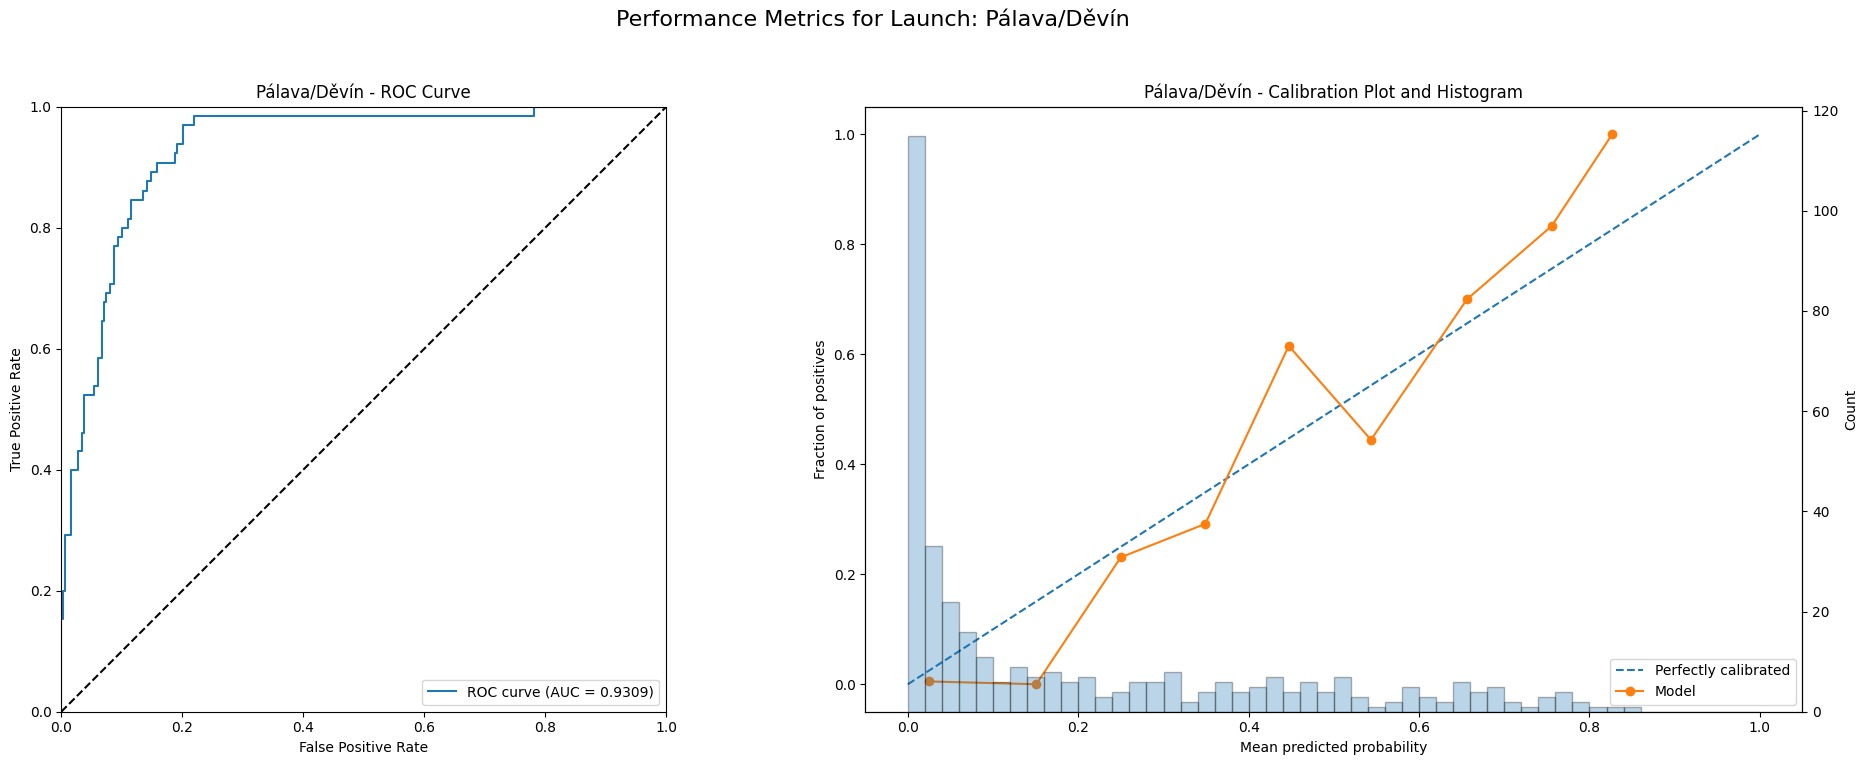

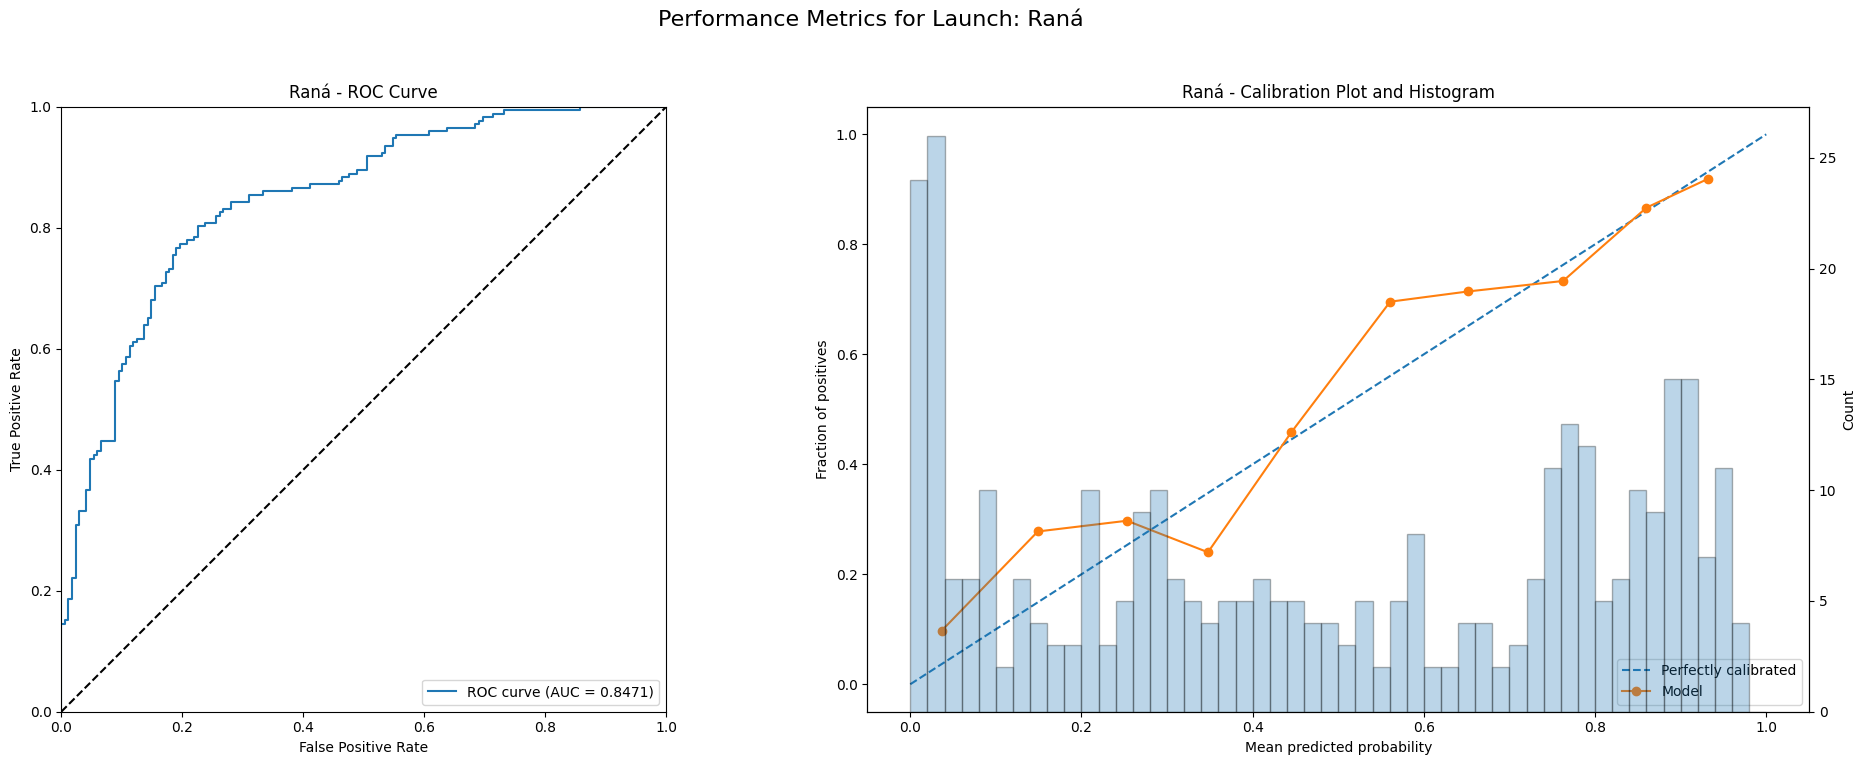

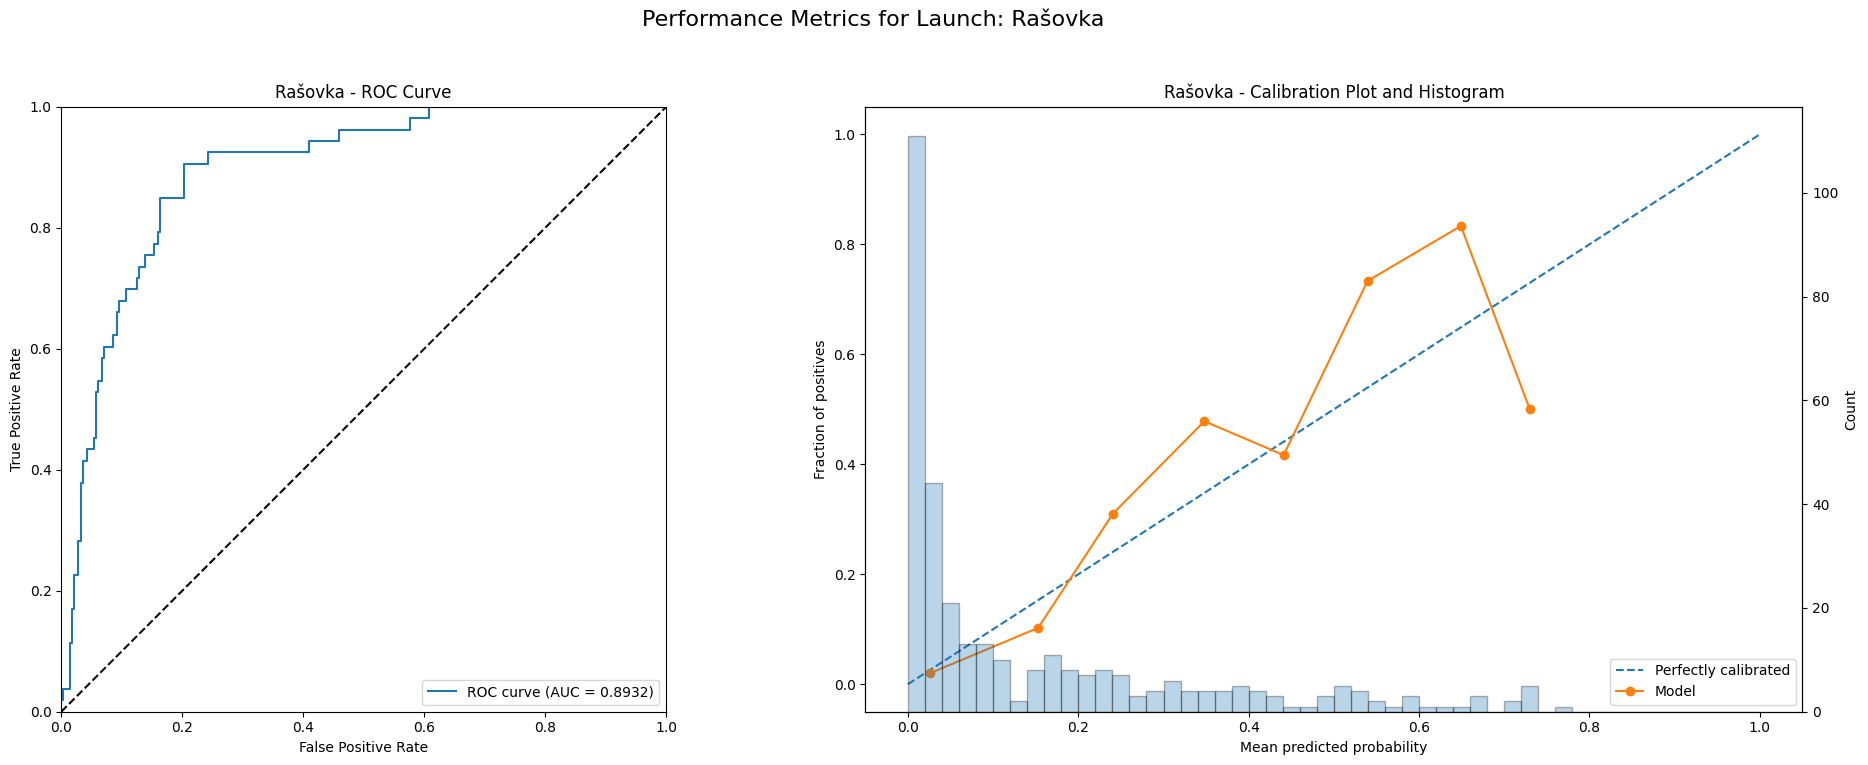

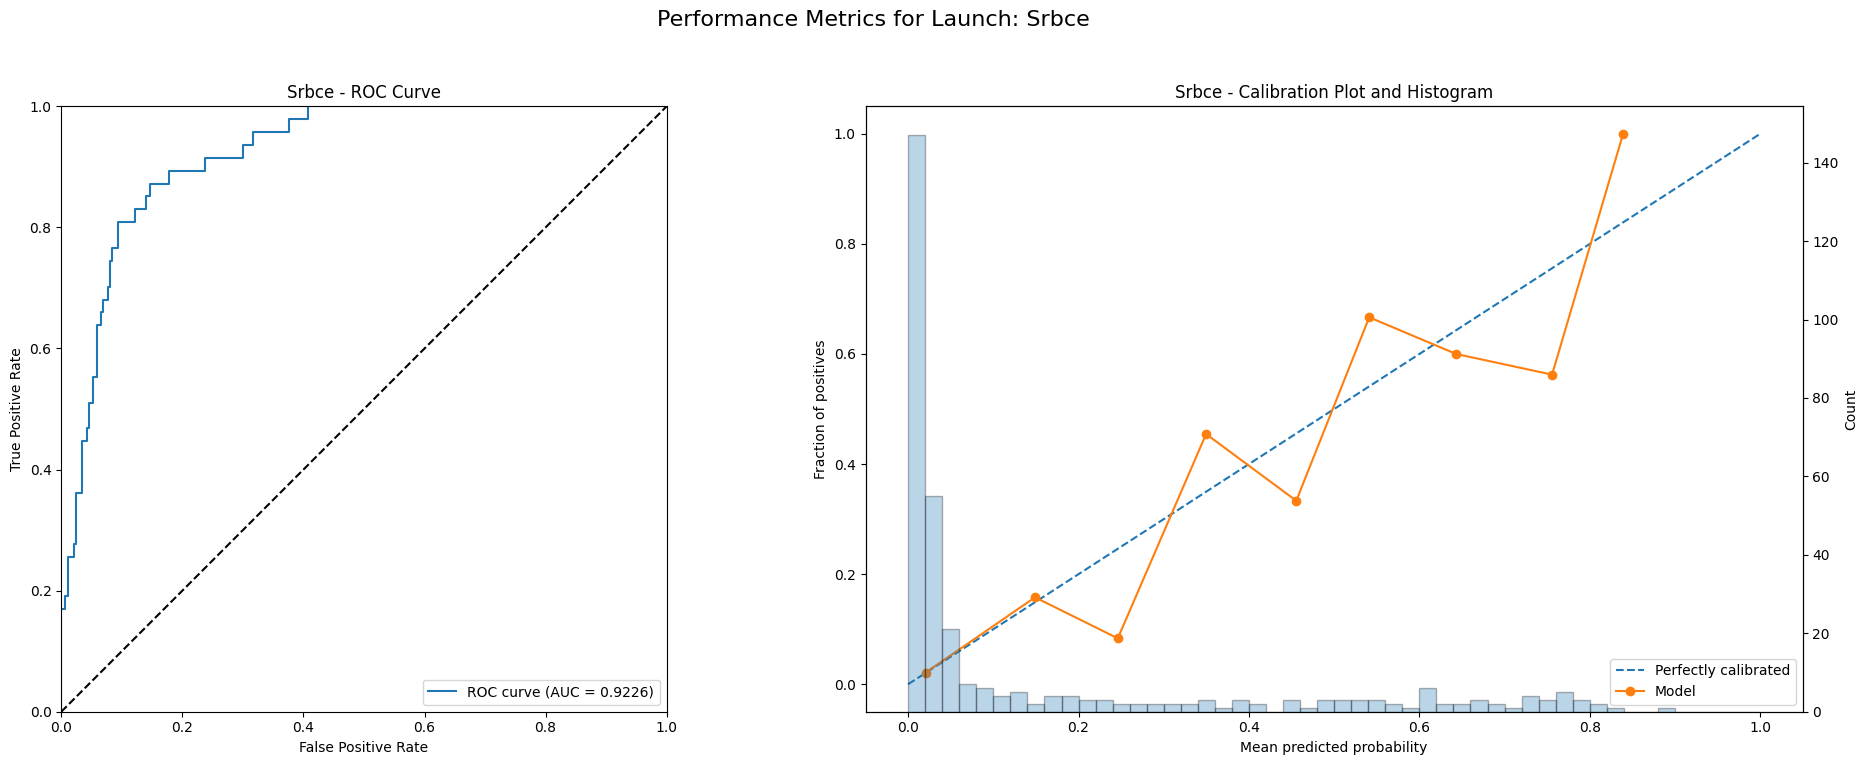

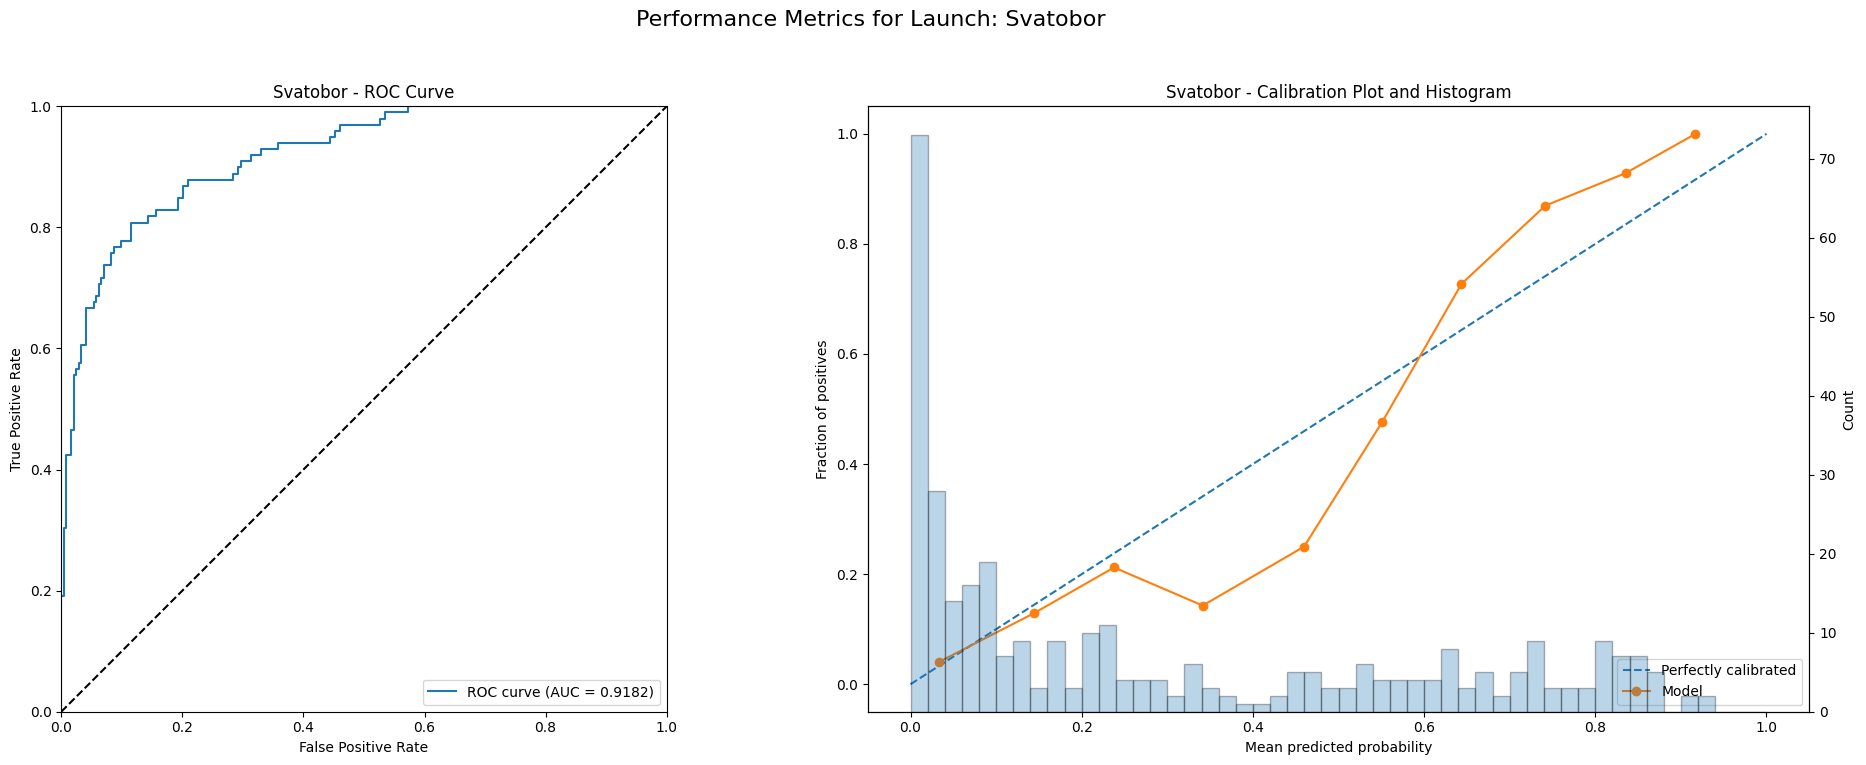

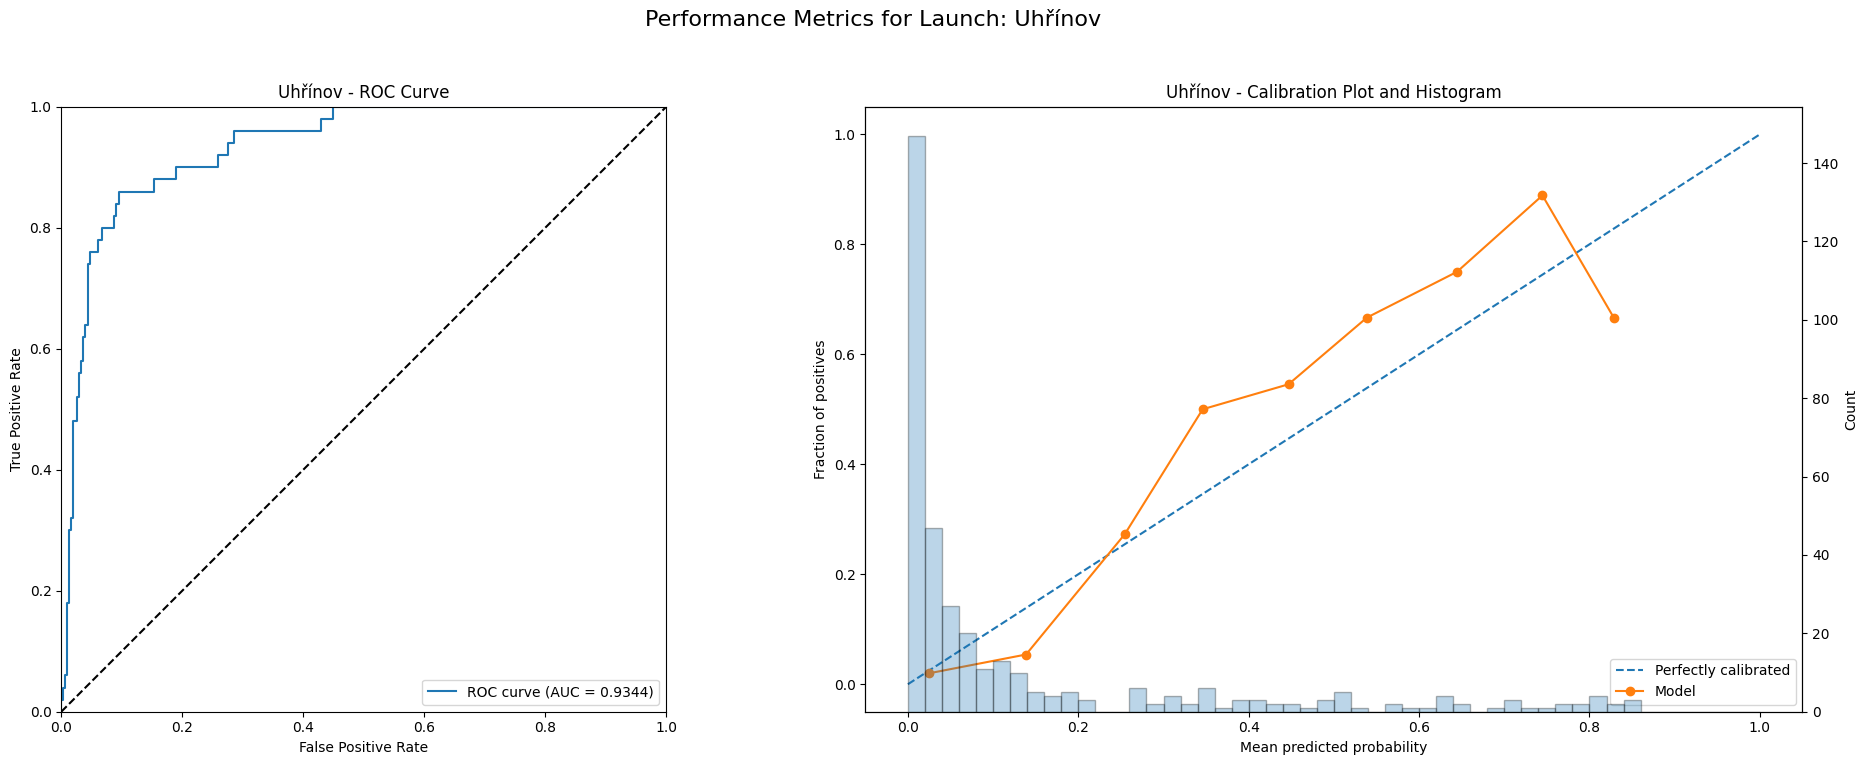

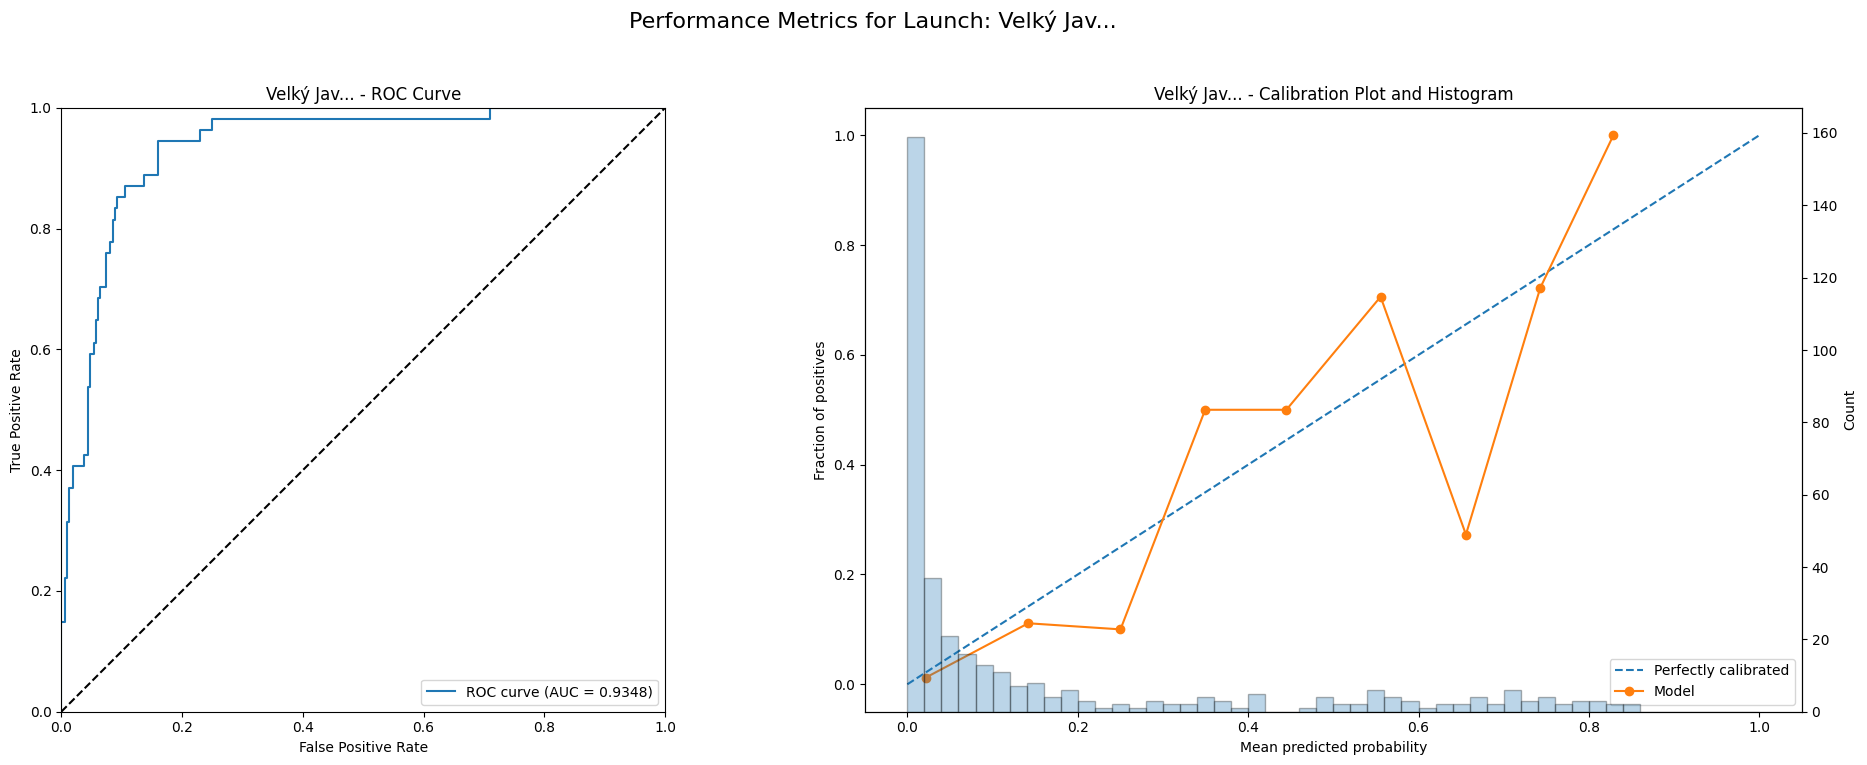

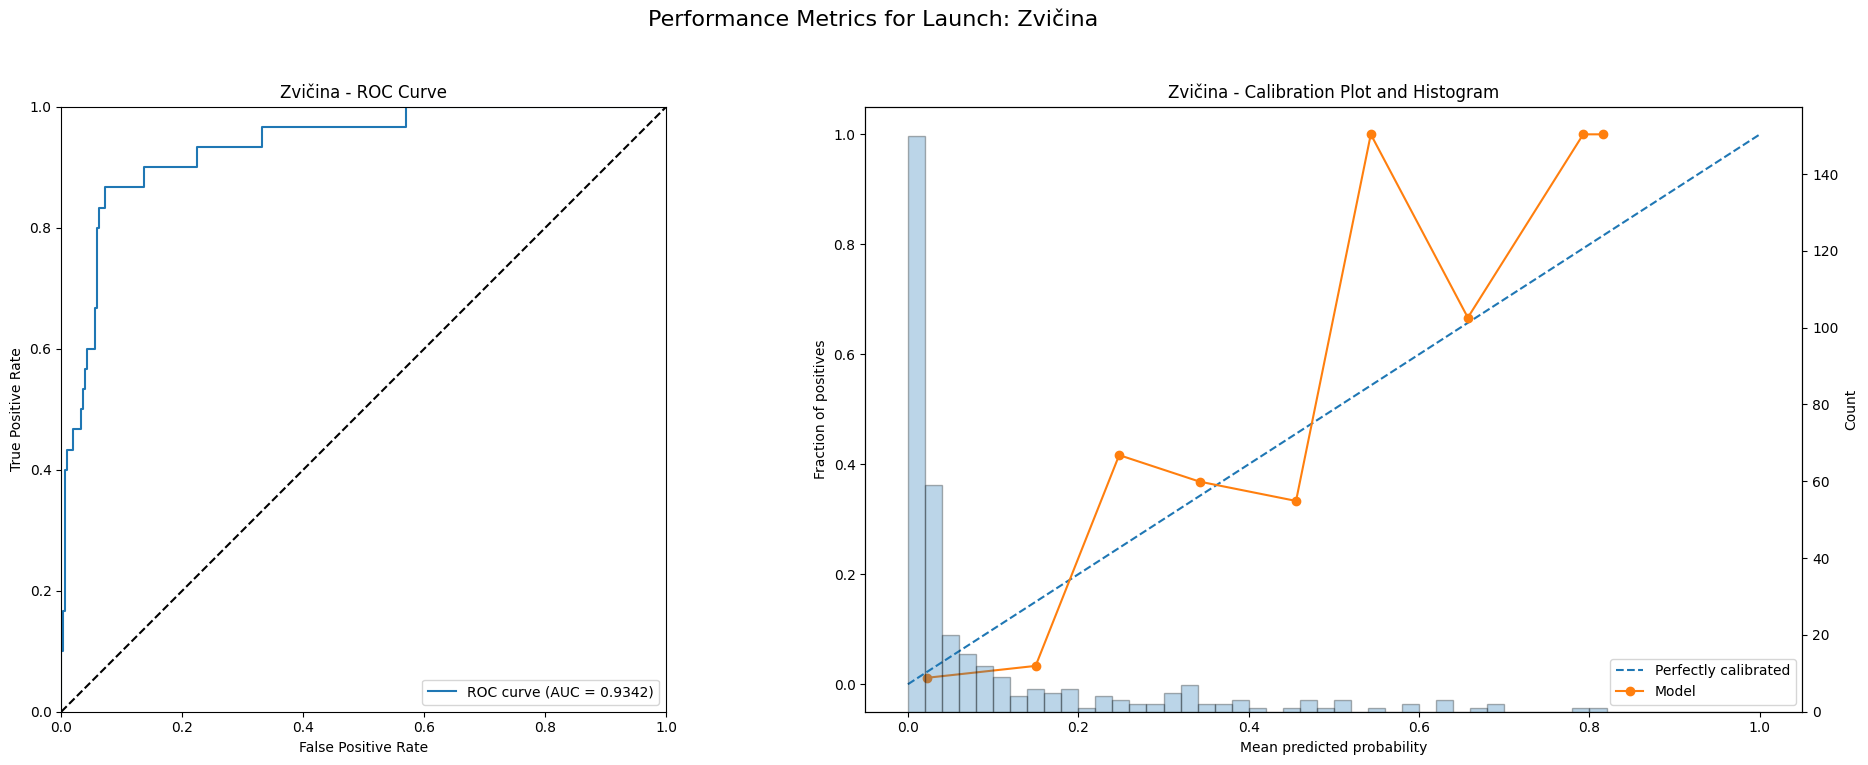

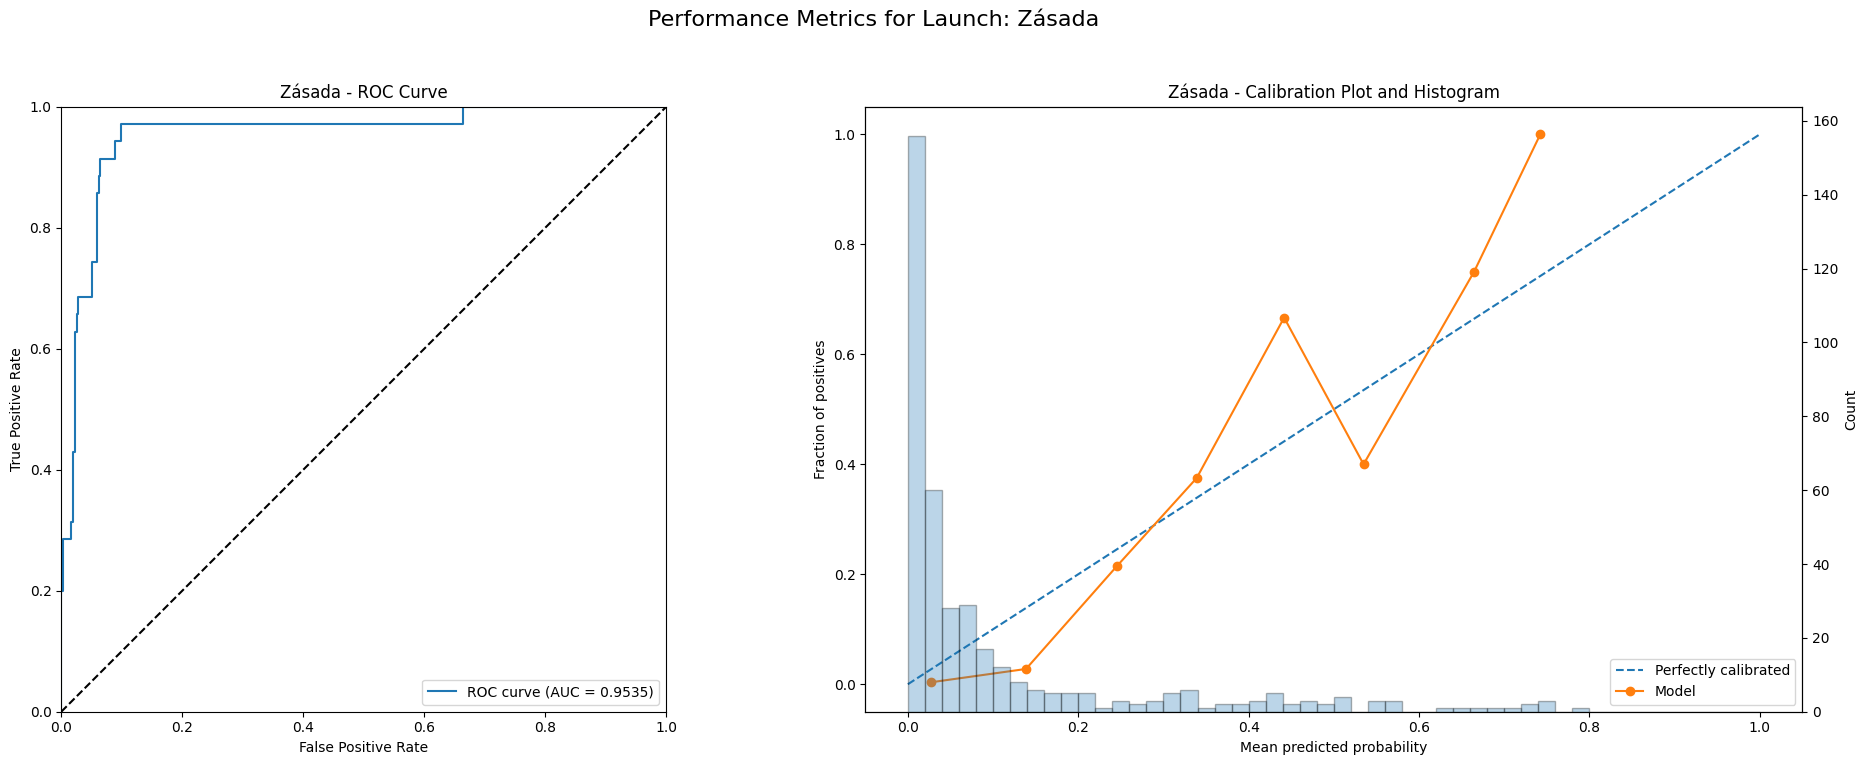

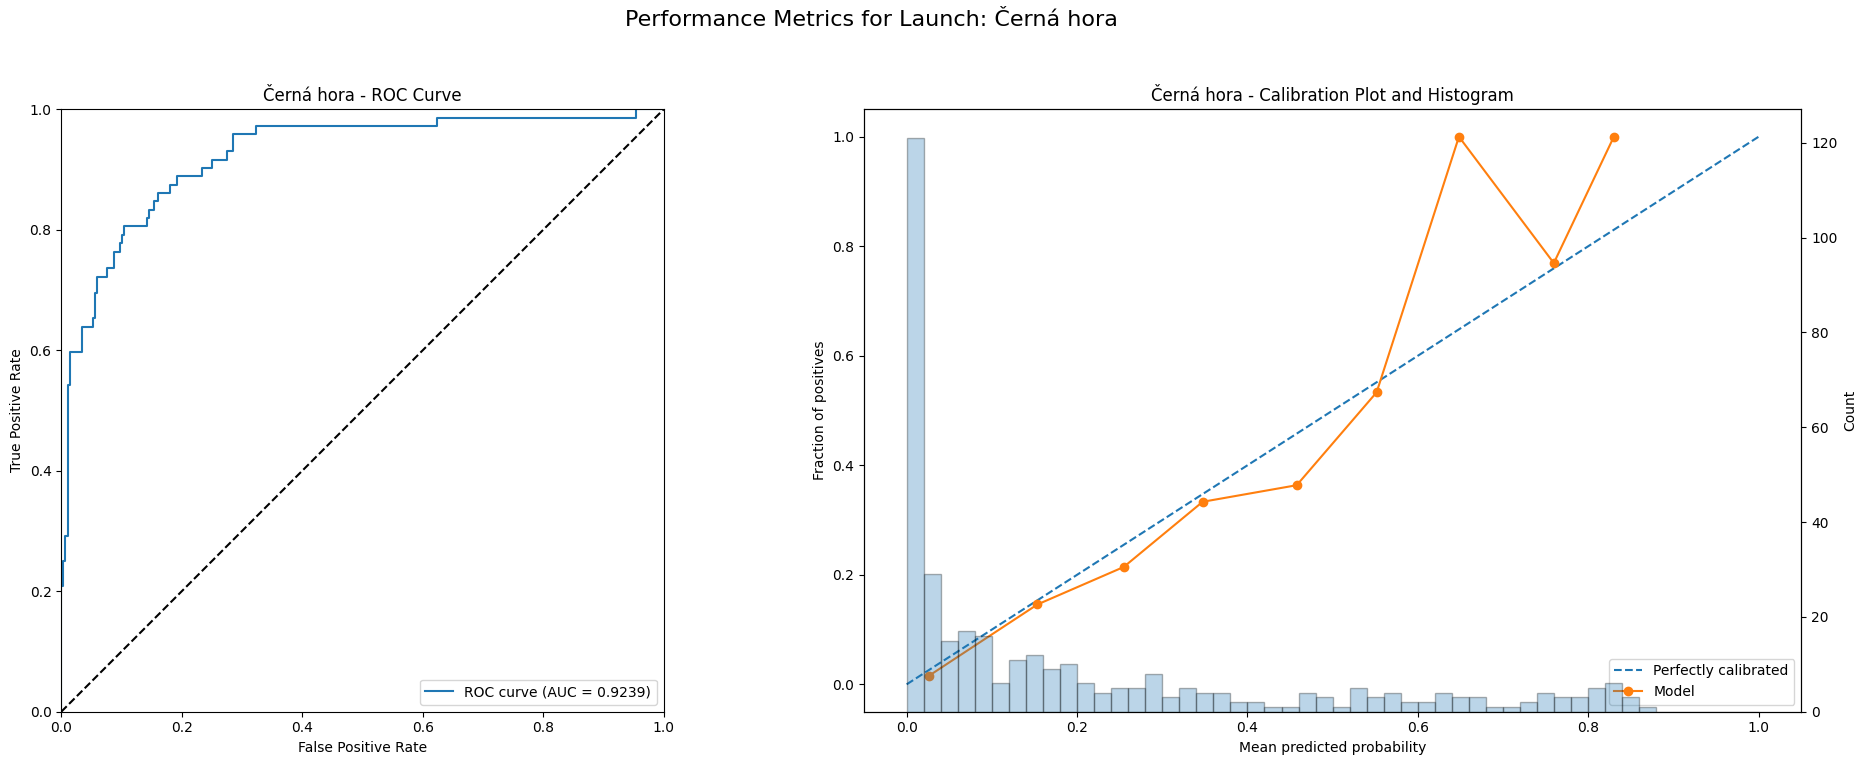

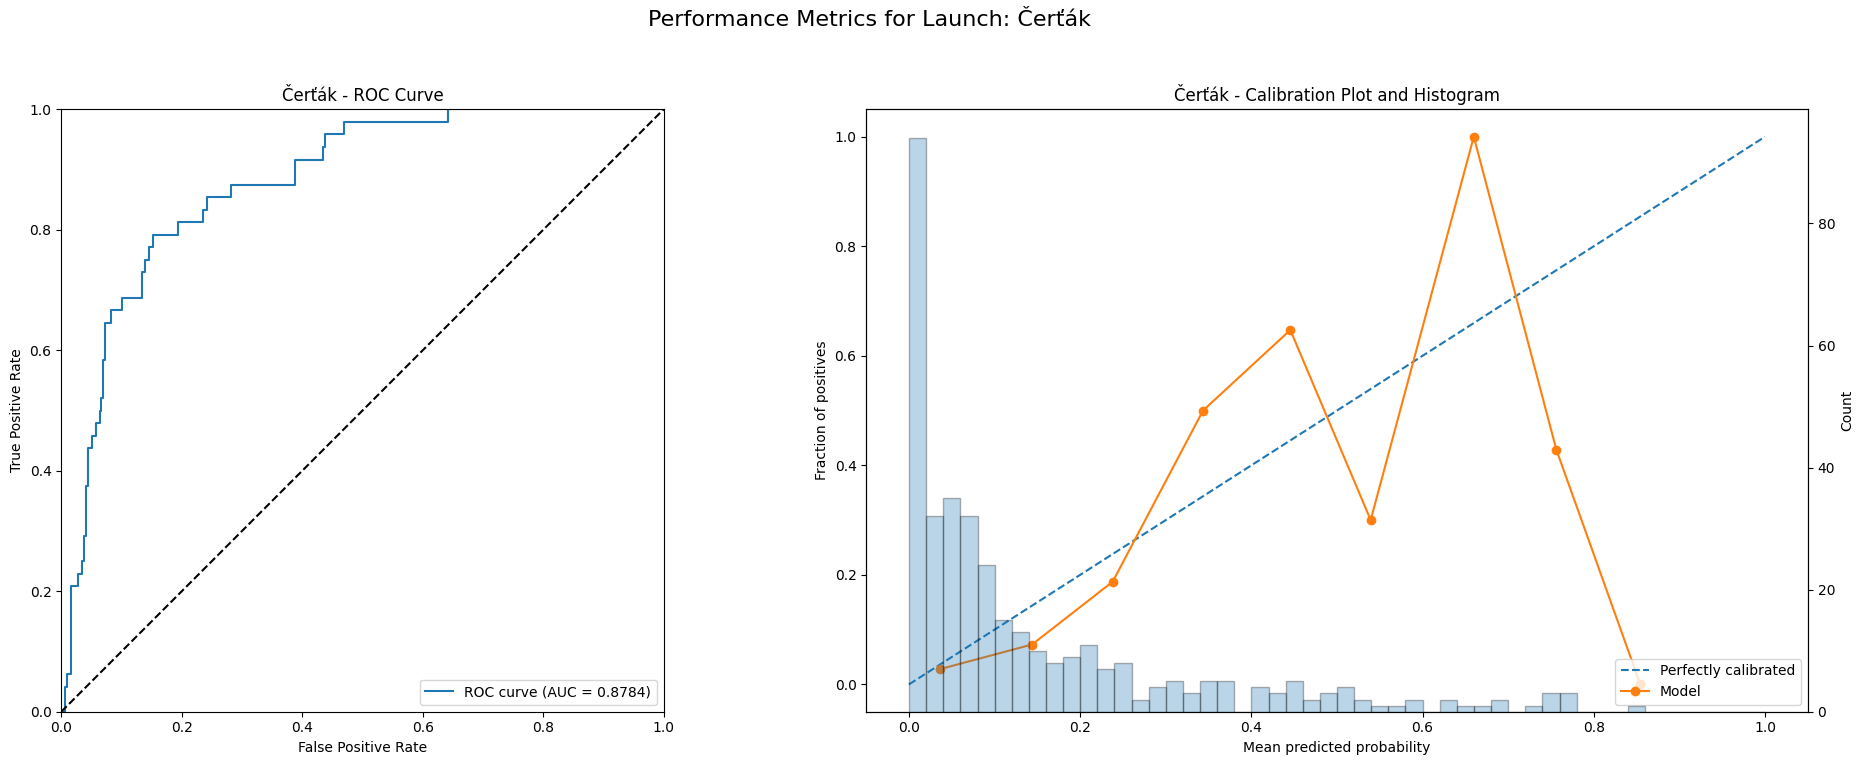

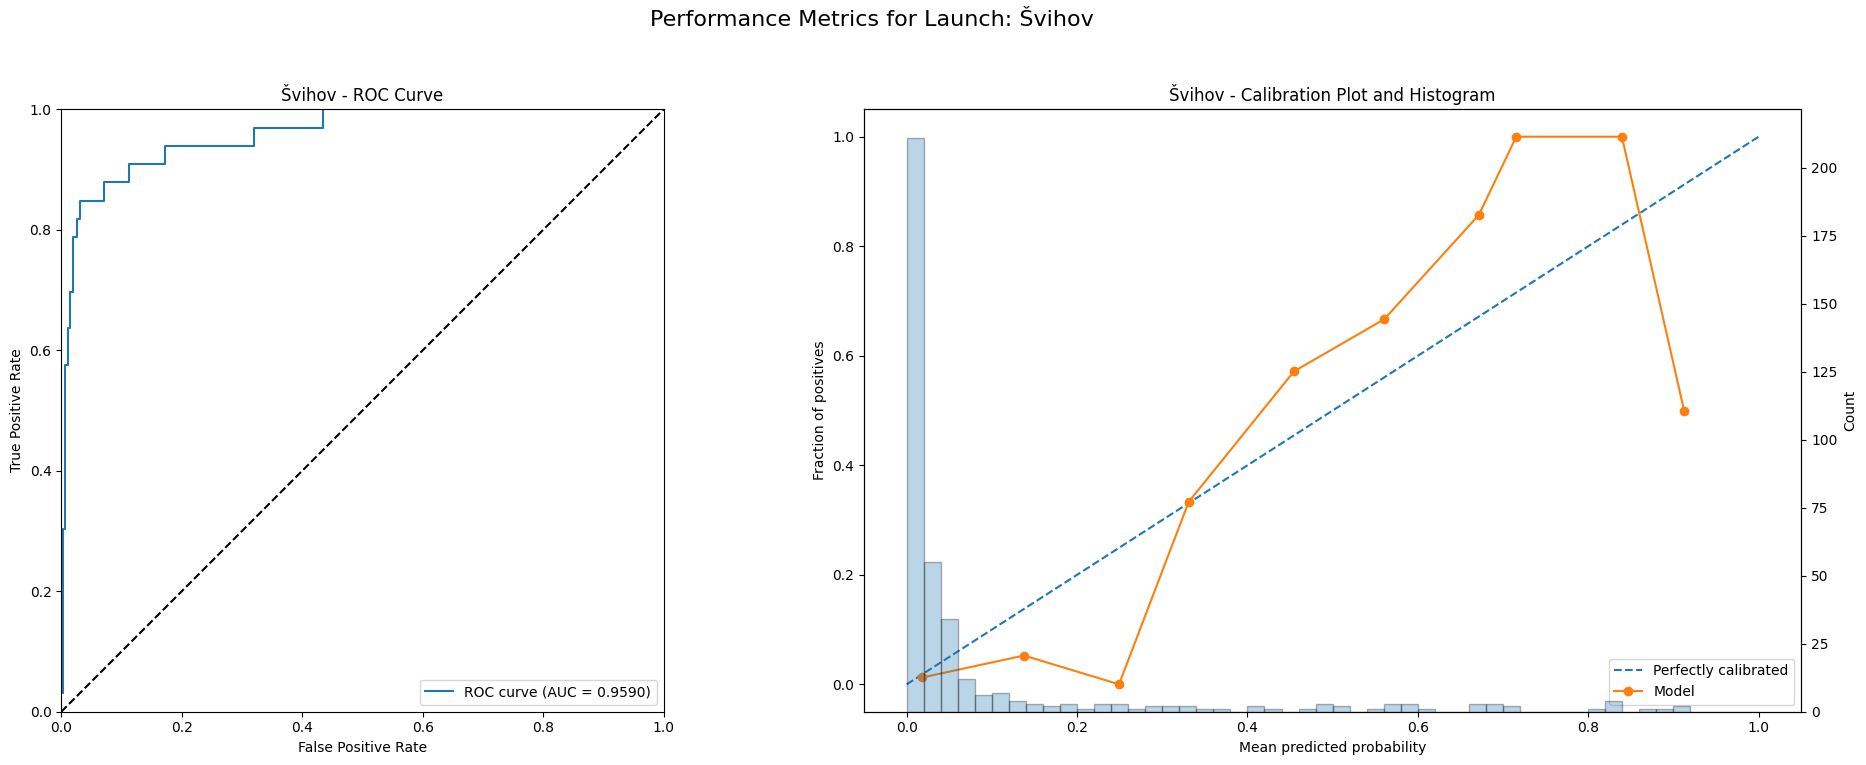

In [9]:
launches = df['launch'].unique()

for launch in launches:
    # Filter validation data for the current launch
    launch_mask = df.loc[y_val.index, 'launch'] == launch
    y_val_launch = y_val[launch_mask]
    y_pred_proba_launch = y_pred_proba[launch_mask]

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot ROC curve on the first subplot, passing ax1
    utils.plot_roc_curve(y_val_launch, y_pred_proba_launch, ax=ax1)
    ax1.set_title(f'{launch} - ROC Curve')
    
    # Plot calibration curve and histogram on the second subplot, passing ax2
    utils.plot_calibration_and_histogram(y_val_launch, y_pred_proba_launch, ax=ax2)
    ax2.set_title(f'{launch} - Calibration Plot and Histogram')
    
    # Set the main title for the figure
    fig.suptitle(f'Performance Metrics for Launch: {launch}', fontsize=16)
    
    # Adjust layout and display the figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()




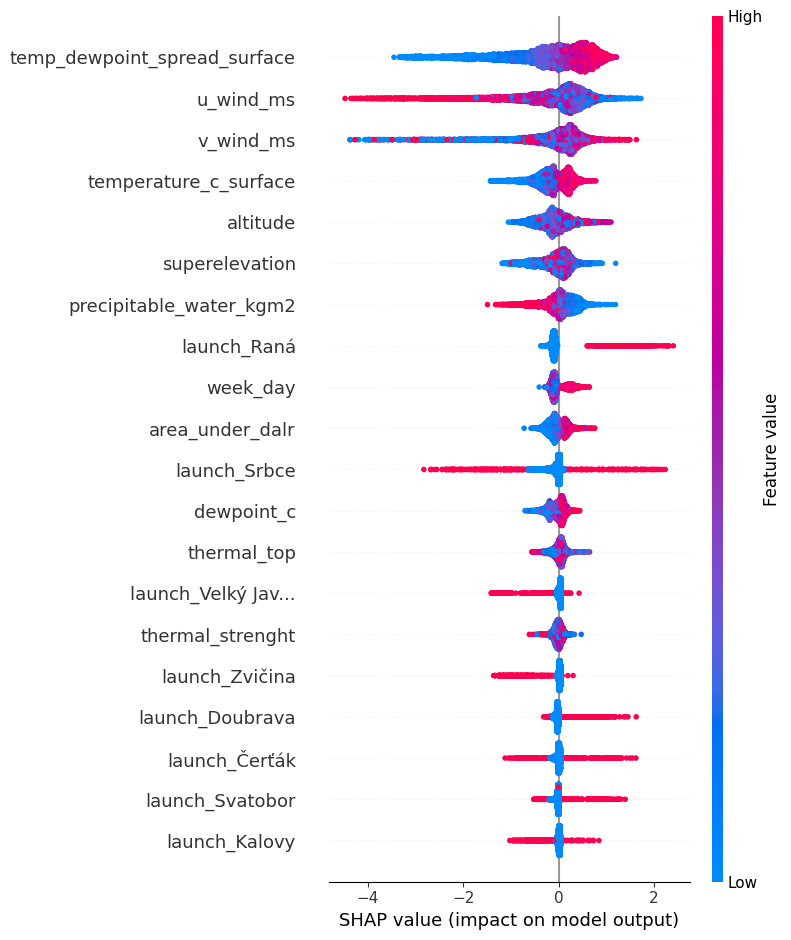

In [10]:
import shap

# Create a SHAP explainer object
explainer = shap.Explainer(model)

# Compute SHAP values
shap_values = explainer(X_val)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_val)

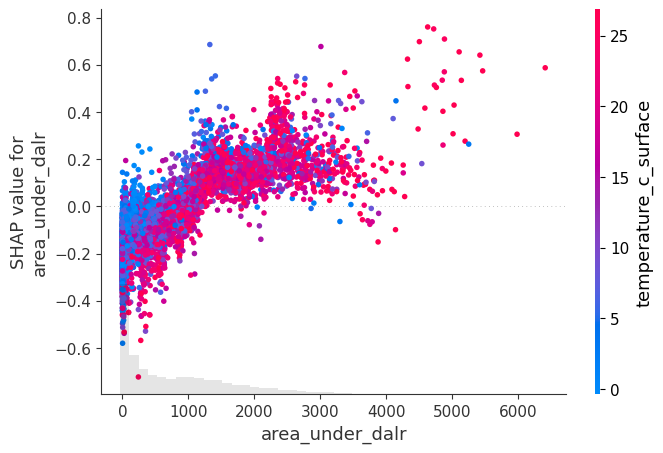

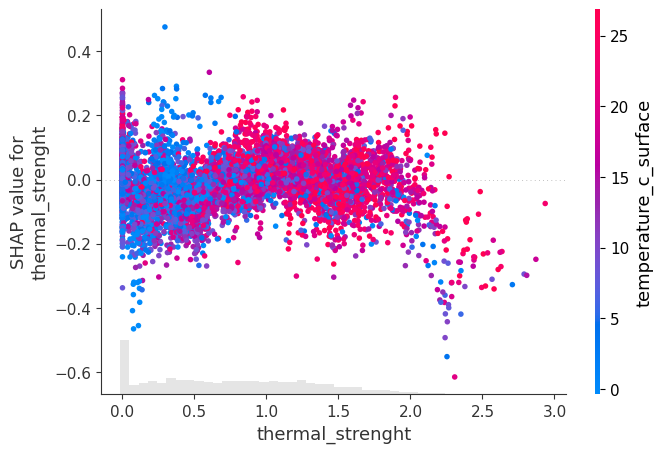

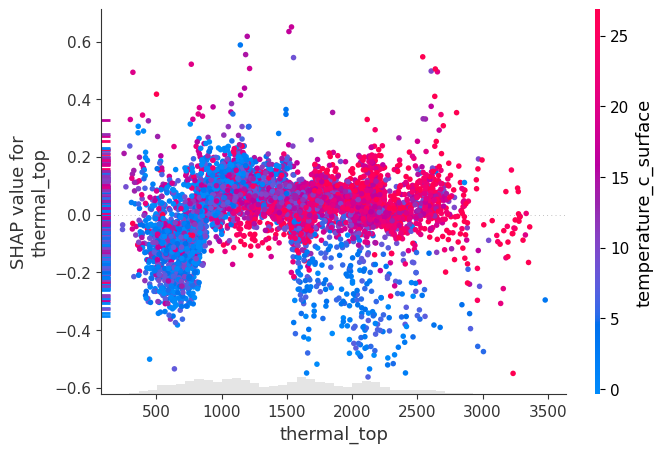

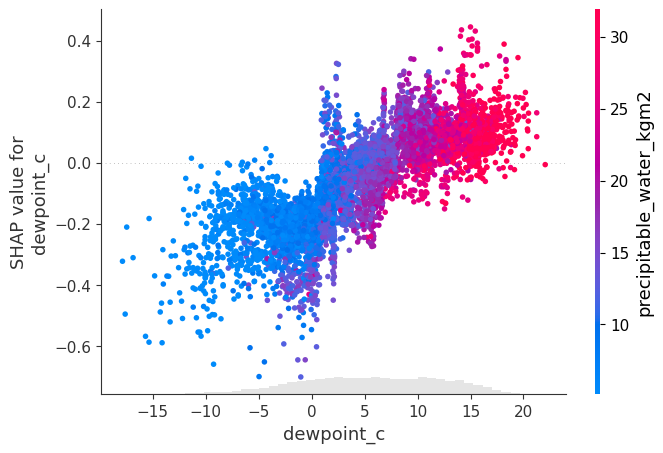

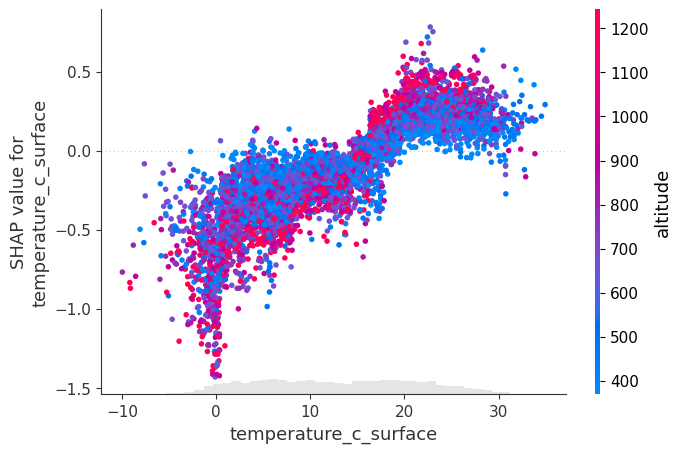

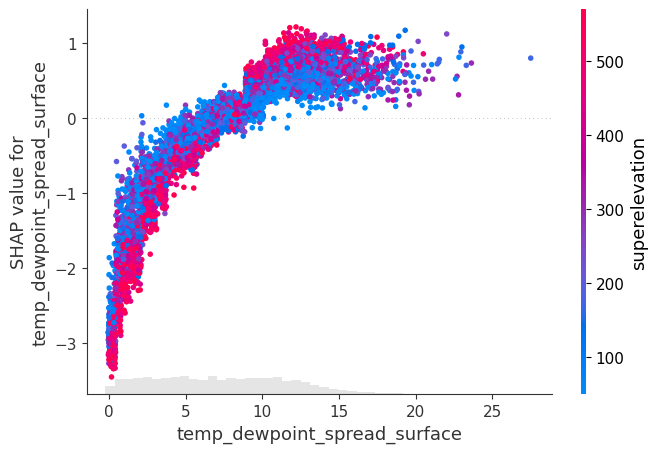

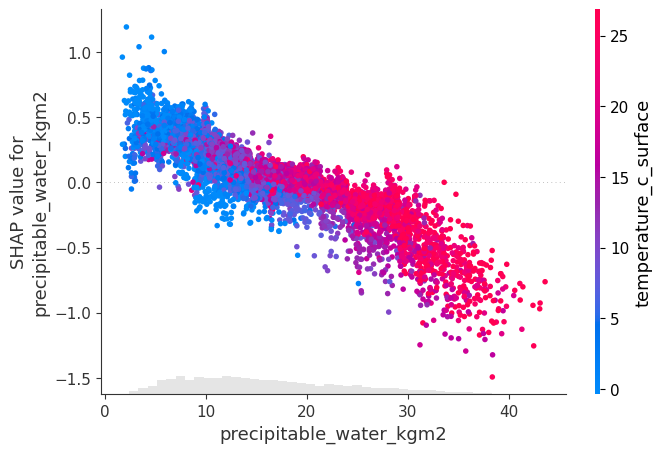

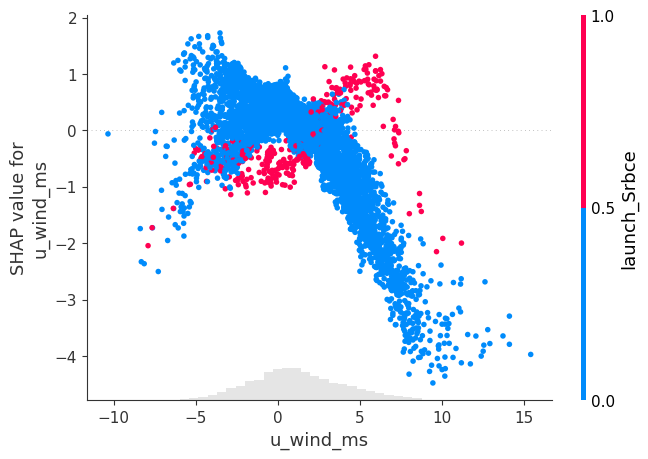

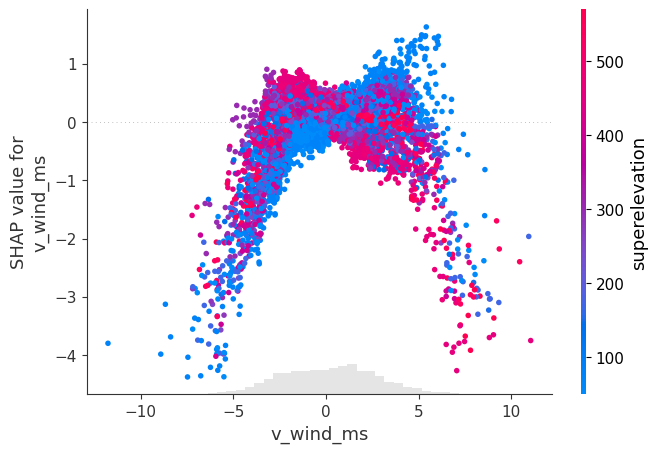

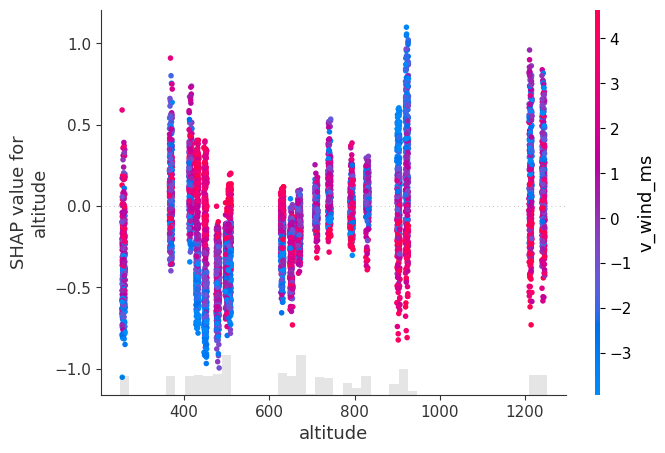

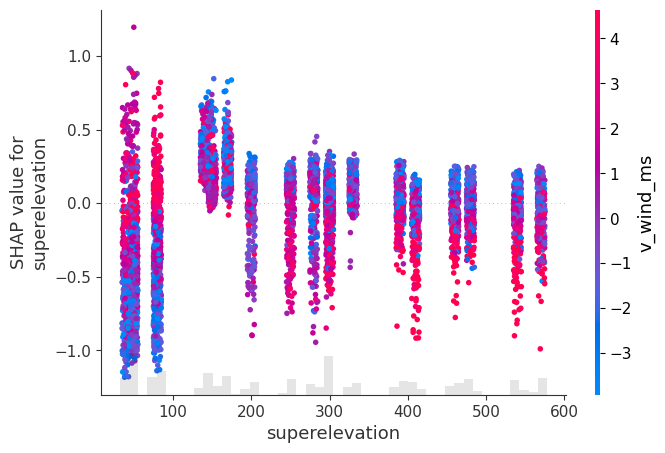

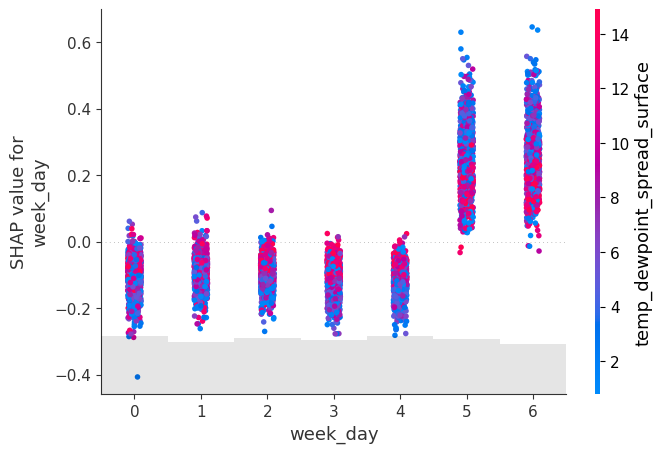

In [11]:
for feature in FEATURES:
    if feature == 'launch':
        continue
    shap.plots.scatter(shap_values[:, feature], color=shap_values)
    plt.show()


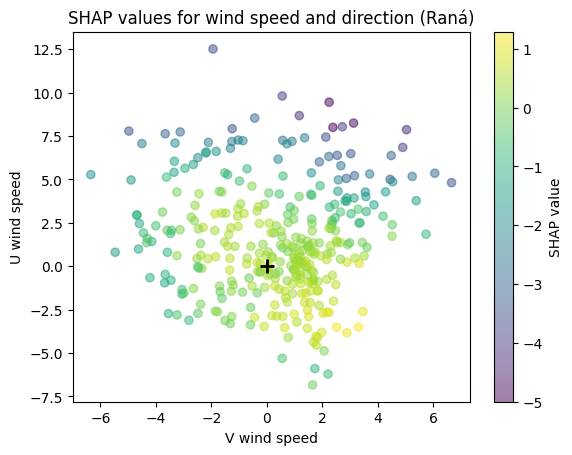

In [12]:
launch = 'Raná'
mask = X_val[f'launch_{launch}'] == 1

utils.scatter_wind_shap_values(shap_values, mask=mask, label=launch);